In [1]:
import pandas as pd
import json, csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
all_players_games_2022_2023 = "https://docs.google.com/spreadsheets/d/1nEk26AUwQsIHWTeLdLKc6U7lL5WnWt2o1CwurPEtQss/gviz/tq?tqx=out:csv&sheet=sample_1"

In [4]:
players_df = pd.read_csv(all_players_games_2022_2023)

In [5]:
pd.set_option('display.max_row', 100)
pd.set_option('display.max_column', 100)

In [6]:
from sklearn.preprocessing import OneHotEncoder


def extract_events(df):
    return (pd.json_normalize(df.events))[["ycrc","rc", "yc"]].fillna(0)


def extract_stats(df):
    sdf = pd.json_normalize(df.stats.apply(lambda x : {k:v for item in eval(x) for k,v in item["stats"].items()}))
    sdf["pass_accuracy"] = (sdf["Accurate passes"].str.extract("\((?P<pass_accuracy>\d+)%").astype(float)/100).fillna(0)
    sdf["accurate_passes"] = (sdf['Accurate passes'].str.extract(r'(?P<passes_number>\d+)/').fillna(0)).astype(int)
    sdf["long_balls_accuracy"] = (sdf["Accurate long balls"].str.extract("\((?P<long_balls_accuracy>\d+)%").astype(float)/100).fillna(0)
    sdf["accurate_long_balls"] = (sdf['Accurate long balls'].str.extract(r'(?P<long_balls_number>\d+)/').fillna(0)).astype(int)
    sdf["Ground duels won"] = (sdf["Ground duels won"].str.extract("\((?P<Ground_duels_won>\d+)%").astype(float)/100).fillna(0)
    sdf = sdf.drop(["Accurate long balls", "Accurate passes"], axis=1)
    sdf["Accurate crosses"] = sdf["Accurate crosses"].str.extract("(?P<Accurate_crosses>\d+)").fillna(0)
    sdf["Tackles won"] = sdf["Tackles won"].str.extract("(?P<Tackles_won>\d+)").fillna(0)
    sdf["Aerial duels won"] = sdf["Aerial duels won"].str.extract("(?P<Aerial_duels_won>\d+)").fillna(0)
    sdf["Successful dribbles"] = sdf["Successful dribbles"].str.extract("(?P<Successful_dribbles>\d+)").fillna(0)
    sdf["Shot accuracy"] = sdf["Shot accuracy"].str.extract("(?P<shots_acc>\d+)").fillna(0)

    sdf = sdf.drop(["Fantasy points", "Acted as sweeper", "Shotmap", "Minutes played"], axis=1)

    sdf = sdf.rename(columns= {"FotMob rating":"rating"})
    return sdf[sdf["rating"] > 0]

# add a row **result** to get the result of the match
def result(x):
    if x > 0:
        return "Win"
    elif x < 0:
        return "Lose"
    else:
        return "Draw"

def cleaning_preprocessing(df):
    players_ndf = df.drop(["imageUrl", "id", "usingOptaId", "saison", "pageUrl", "Unnamed: 30", "Unnamed: 0.1",	"Unnamed: 0", "shortName", "positionStringShort", "matchUrl", "teamData", "usualPosition", "fantasyScore", "shirt", "positionRow"],axis=1)
    players_ndf = players_ndf[~players_ndf["rating"].isna()]
    players_ndf = players_ndf[~players_ndf["role"].isna()]
    players_ndf["isSubbedOn"] = players_ndf["timeSubbedOn"].fillna(0).apply(lambda x:1 if x > 0 else 0)
    players_ndf["isSubbedOff"] = players_ndf["timeSubbedOff"].fillna(0).apply(lambda x:1 if x > 0 else 0)
    players_ndf = players_ndf.drop(["timeSubbedOn", "timeSubbedOff"],axis=1)

    # convert to json
    columns = ["name", "events", "rating","shotmap"]
    for column in columns:
        players_ndf[column] = players_ndf[column].apply(lambda x:eval(x))

    # add a row **team_score** to get the goals scored by the player's team 
    players_ndf["team_score"] = np.where(players_ndf['home_team'] == players_ndf.teamName,
                                            players_ndf['score'].str.split(" - ").apply(lambda x: x[0]),
                                            players_ndf['score'].str.split(" - ").apply(lambda x: x[1]))

    # add a row **opponent_score** to get the goals scored by the opponent team
    players_ndf["opponent_score"] = np.where(players_ndf['away_team'] == players_ndf.teamName,
                                            players_ndf['score'].str.split(" - ").apply(lambda x: x[0]),
                                            players_ndf['score'].str.split(" - ").apply(lambda x: x[1]))

    players_ndf["score_difference"] = players_ndf["team_score"].astype(int) - players_ndf["opponent_score"].astype(int)

    #match result
    players_ndf["result"] = players_ndf["score_difference"].apply(lambda x : result(x))


    encoder = OneHotEncoder(sparse=False)
    result_encoded = encoder.fit_transform(players_ndf[["result"]])

    #players_ndf = players_ndf.join(pd.get_dummies(players_ndf["result"], prefix='Result'))

    category_names = encoder.categories_[0]
    result_df = pd.DataFrame(result_encoded, columns=[f'Result_{cat}' for cat in category_names])

    players_ndf = pd.concat([players_ndf.reset_index(drop=True), result_df], axis=1)

    # extract events and stats
    stats_df = extract_stats(players_ndf)
    events_df = extract_events(players_ndf)

    players_ndf = players_ndf.drop(["score", "events", "stats", "rating" ,"shotmap", "teamName", "home_team",	"away_team", "name","result"], axis=1)

    players_ndf = players_ndf.reset_index(drop=True)

    # merge dfs
    merged_df = pd.merge(events_df, stats_df, how='inner', right_index=True, left_index=True)
    
    merged_df = merged_df.merge(players_ndf, how='inner', left_index=True, right_index=True)

    return merged_df

In [7]:
players_cdf = cleaning_preprocessing(players_df)

In [8]:
from sklearn.model_selection import train_test_split

# split dataframe
def split_df(df):
    X, y = df.drop("rating", axis=1), df["rating"]
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,)
    X_train, X_test, y_train, y_test = X.iloc[:round(len(X)*0.8)], X.iloc[round(len(X)*0.8):], y.iloc[:round(len(X)*0.8)], y.iloc[round(len(X)*0.8):]
    return X_train, X_test, y_train, y_test

In [9]:
from sklearn.model_selection import learning_curve

# draw learning cure
def evaluation(model, X_train, y_train, X_test, y_test):

    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=5, scoring = 'neg_mean_squared_error',
                                               train_sizes=np.linspace(0.1, 1, 10))
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()

# Keeper


best score : 90.2%

In [ ]:
def preprocess_keeper(df):
    keeper = df.query(f"role == 'Keeper'")
    means = keeper.isna().mean()
    c_todrop = means[means == 1.0].index.tolist()
    keeper = keeper.drop(c_todrop, axis=1)
    keeper = keeper.drop(["role", "opponent_score"], axis=1)
    keeper["Saving_accuracy"] = keeper["Saves"] / (keeper["Saves"] + keeper["Goals conceded"])
    return keeper.fillna(0).astype(float)

In [ ]:
keeper_df = preprocess_keeper(players_cdf)


<Axes: xlabel='rating', ylabel='Density'>

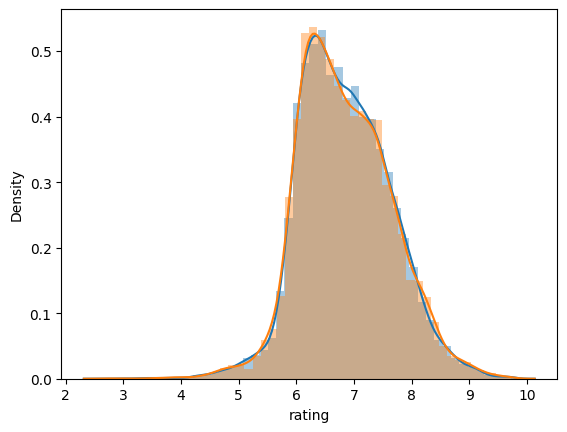

In [ ]:
sns.distplot(players_cdf.iloc[:round(len(players_cdf)*0.8)].rating)
sns.distplot(players_cdf.iloc[round(len(players_cdf)*0.8):].rating)

## test different models

- **best models** : 
      BayesianRidge 	R2 score: 0.8913373247460569
      lgbR 	R2 score: 0.8871086678889389
      SVR 	R2 score: 0.8929820224434657



GradientBoostingRegressor 	R2 score: 0.8858117602848357
RandomForestRegressor 	R2 score: 0.860253892790737
LinearRegression 	R2 score: 0.8910071112468934
Ridge 	R2 score: 0.892179917157035
XGBRegressor 	R2 score: 0.8723200604165351
BayesianRidge 	R2 score: 0.8913373247460564
LassoLarsIC 	R2 score: 0.8909792912893185
lgbR 	R2 score: 0.8871086678889389
SVR 	R2 score: 0.8929820224434657


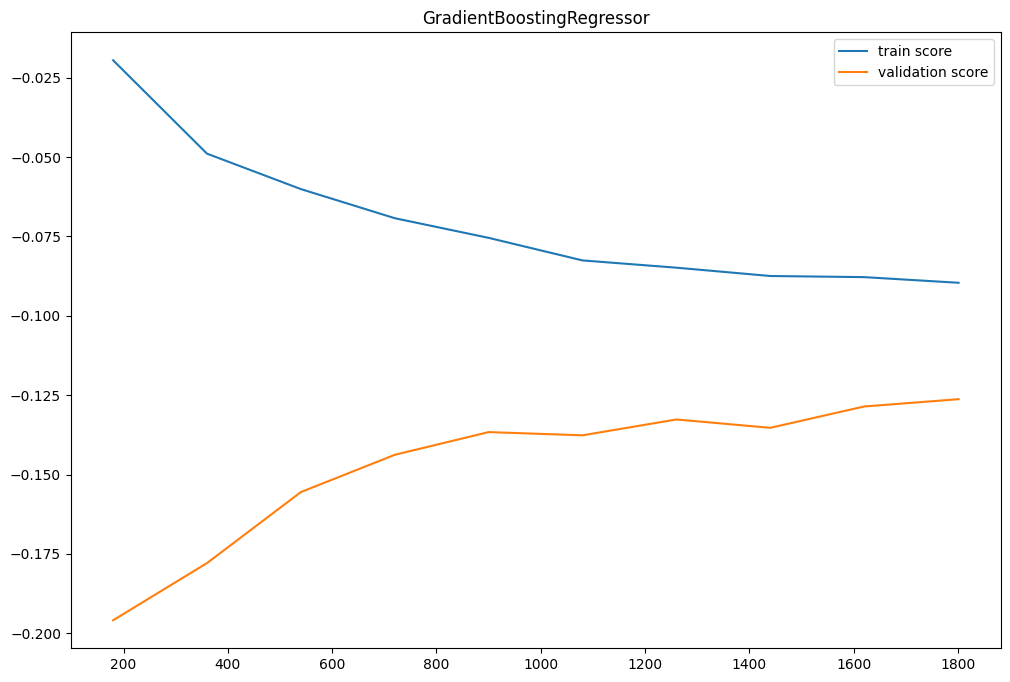

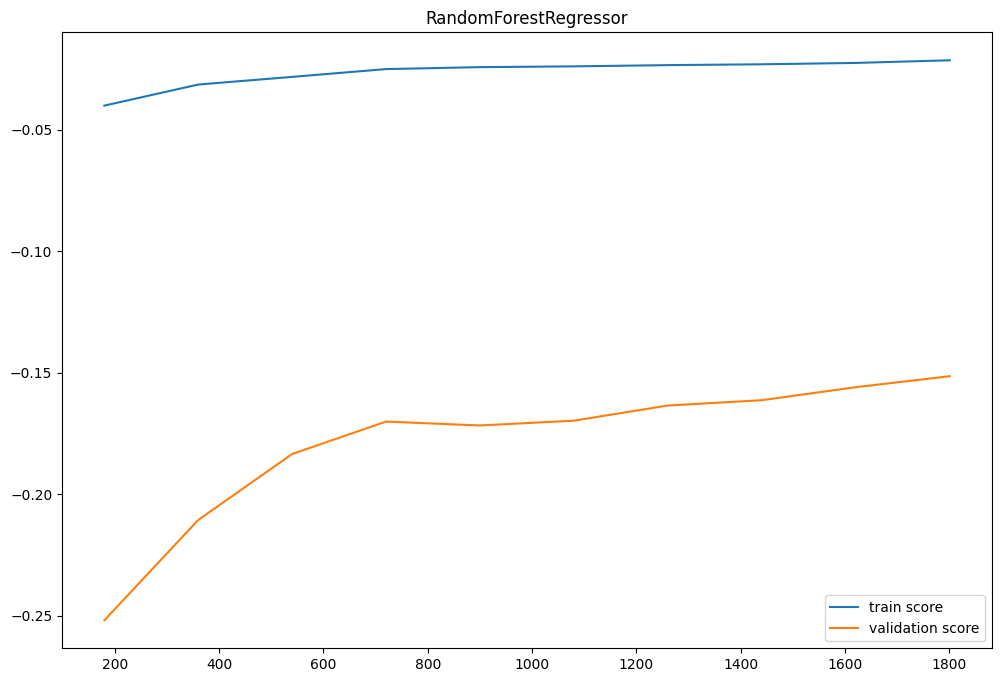

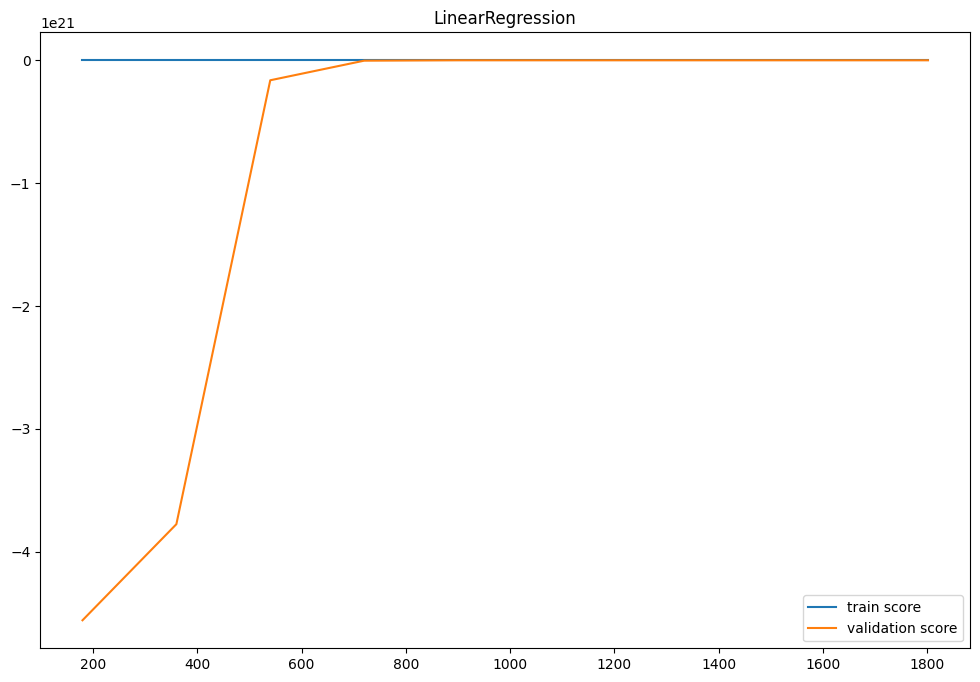

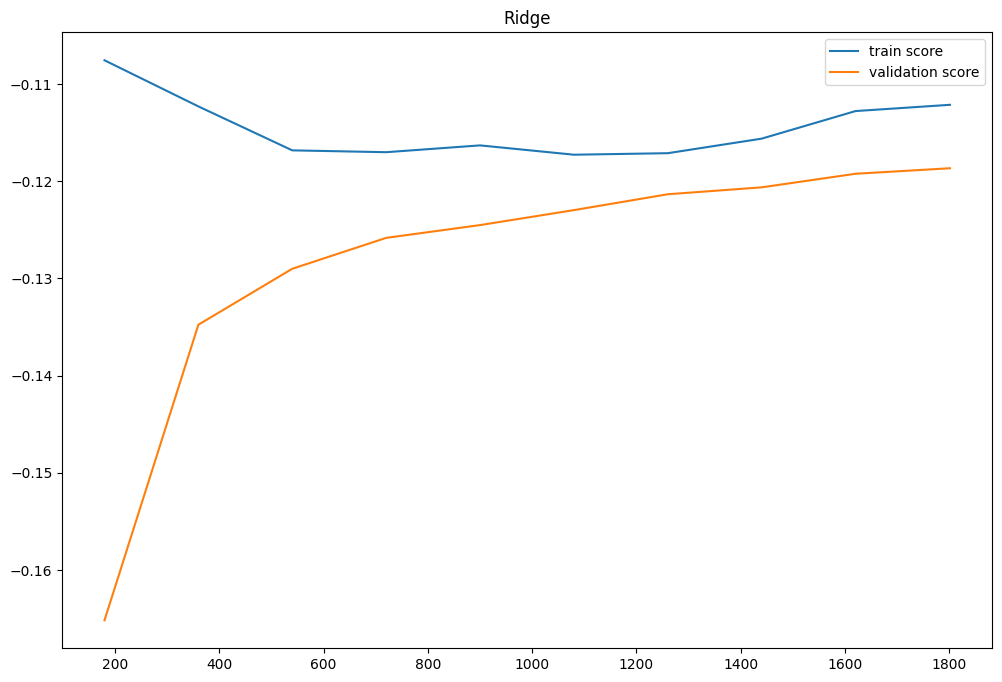

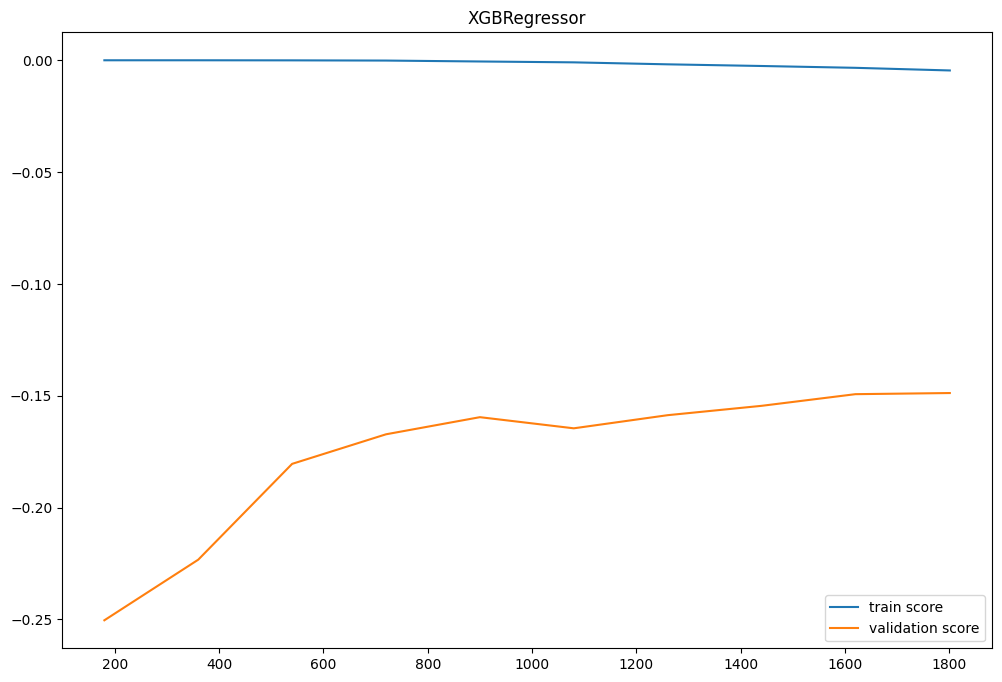

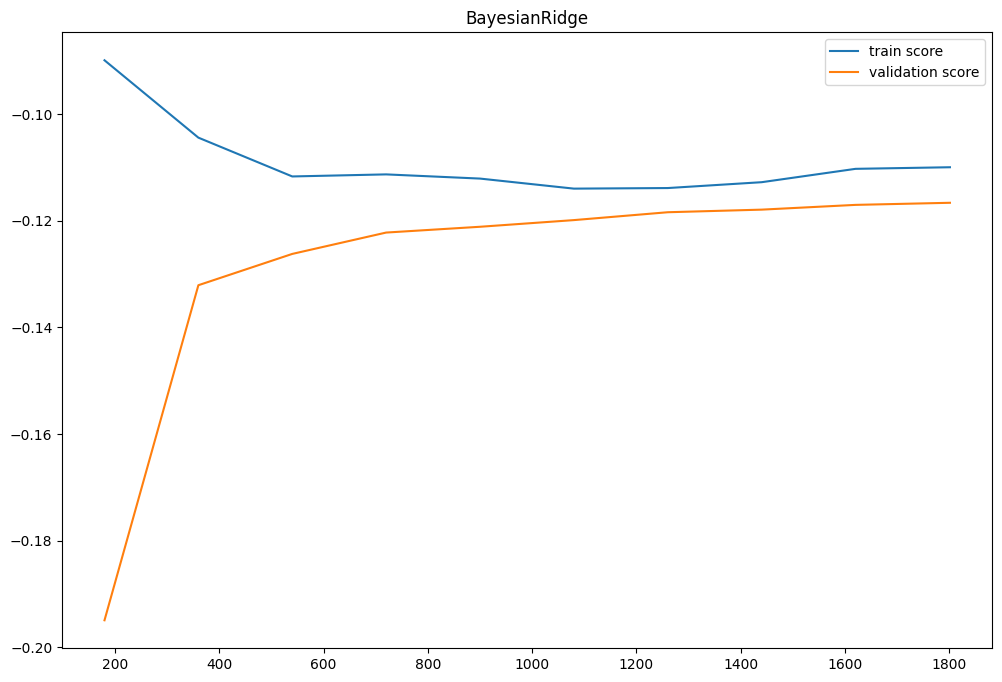

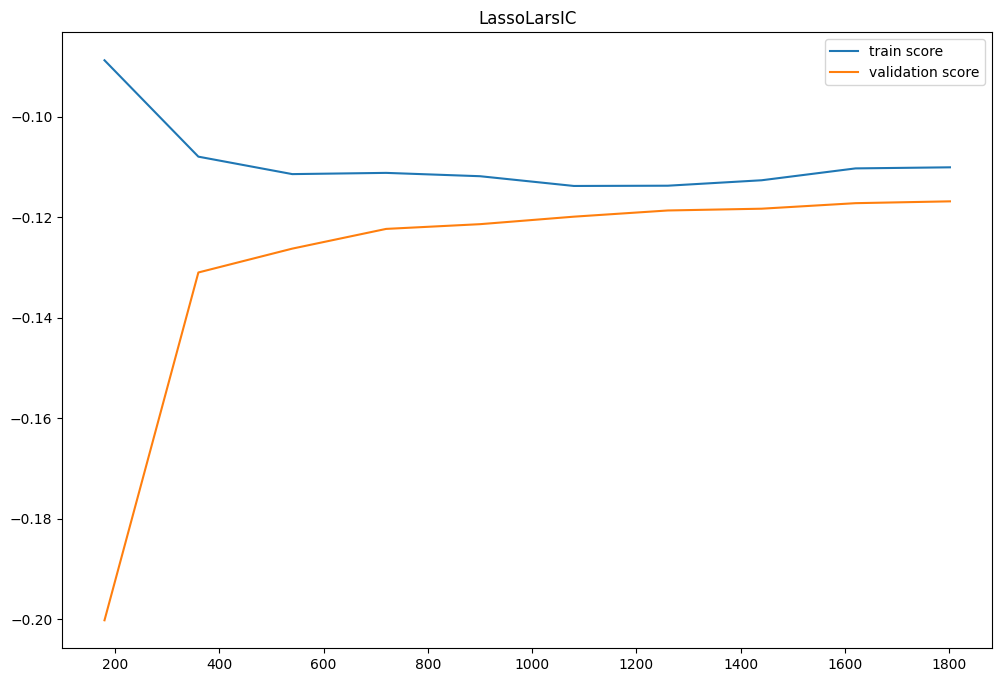

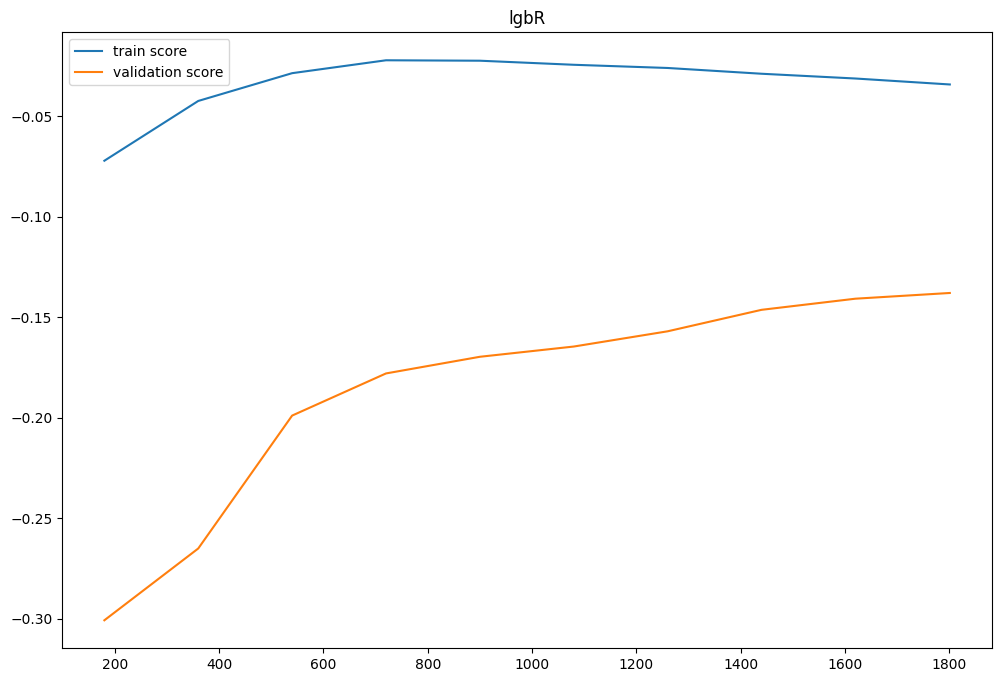

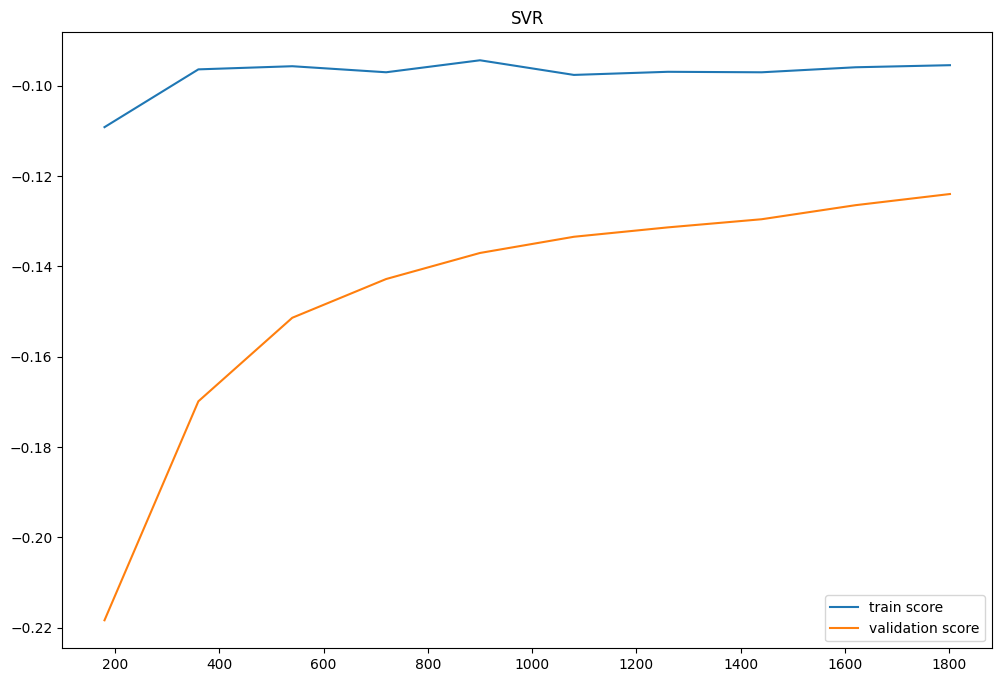

In [ ]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge,Lasso, BayesianRidge, LassoLarsIC,ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
import lightgbm as lgb
from sklearn.svm import SVR



regressors = {
    "GradientBoostingRegressor" : GradientBoostingRegressor(),
    "RandomForestRegressor" : RandomForestRegressor(),
    "LinearRegression" : LinearRegression(),
    "Ridge" : Ridge(),
    "XGBRegressor" : XGBRegressor(),
    "BayesianRidge" : BayesianRidge(),
    "LassoLarsIC" : LassoLarsIC(),
    "lgbR" : lgb.LGBMRegressor(),
    "SVR":SVR()
}

X_train, X_test, y_train, y_test = split_df(keeper_df)
for model_name in regressors:
    model = make_pipeline(MinMaxScaler(), regressors[model_name])
    evaluation(model, X_train, y_train, X_test, y_test)
    plt.title(model_name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(model_name, "\tR2 score:", r2_score(y_test, y_pred))

## improving the score

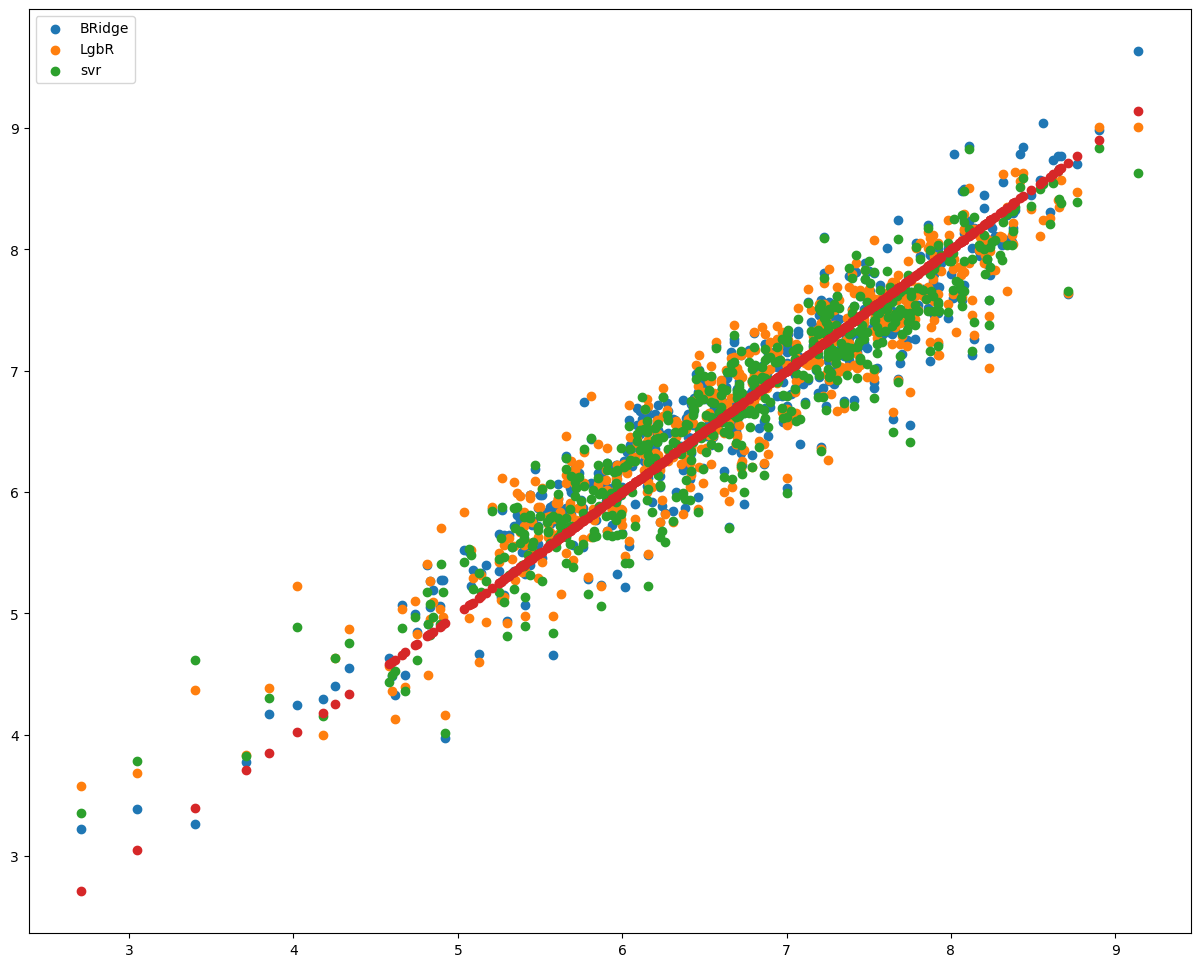

In [ ]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

keeper_df["total_shots"] = keeper_df.Saves + keeper_df["Goals conceded"]
X_train, X_test, y_train, y_test = split_df(keeper_df)

pr = make_pipeline(MinMaxScaler())

plt.figure(figsize=(15,12))
BRidge = make_pipeline(pr, BayesianRidge())
BRidge.fit(X_train, y_train)
plt.scatter(y_test, BRidge.predict(X_test), label="BRidge")

LgbR = make_pipeline(pr, lgb.LGBMRegressor())
LgbR.fit(X_train, y_train)
plt.scatter(y_test, LgbR.predict(X_test), label="LgbR")

svr = make_pipeline(pr, SVR())
svr.fit(X_train, y_train)
plt.scatter(y_test, svr.predict(X_test), label="svr")

plt.scatter(y_test, y_test)
plt.legend()



In [ ]:
print("BRidge", BRidge.score(X_test, y_test))
print("LgbR",LgbR.score(X_test, y_test))
print("svr",svr.score(X_test, y_test))


BRidge 0.891339718240528
LgbR 0.8845658460385877
svr 0.8927993667304422


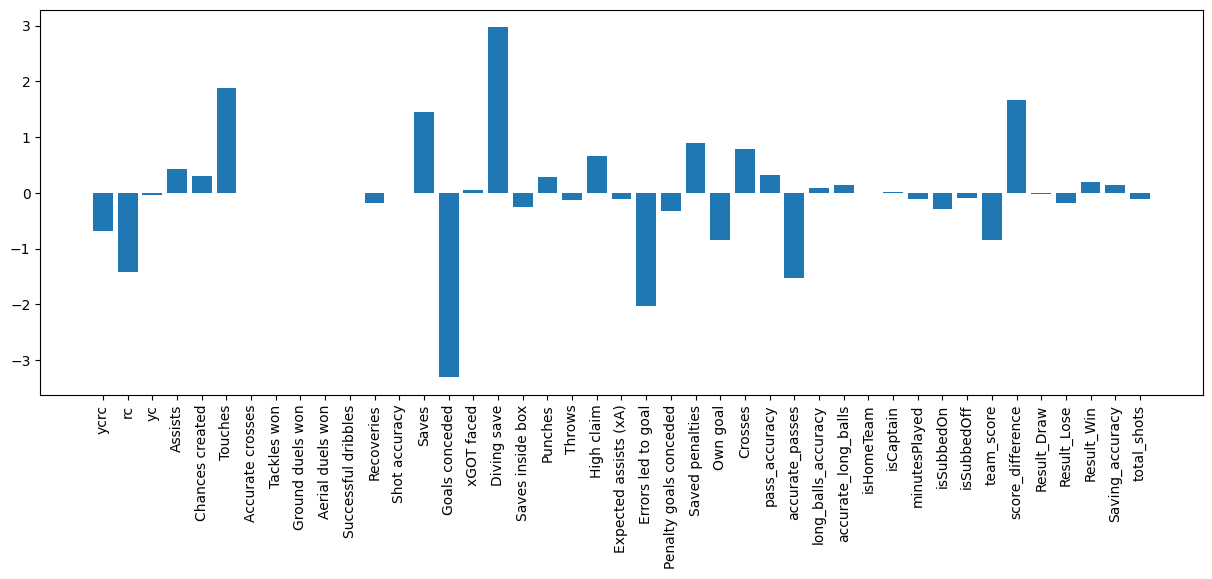

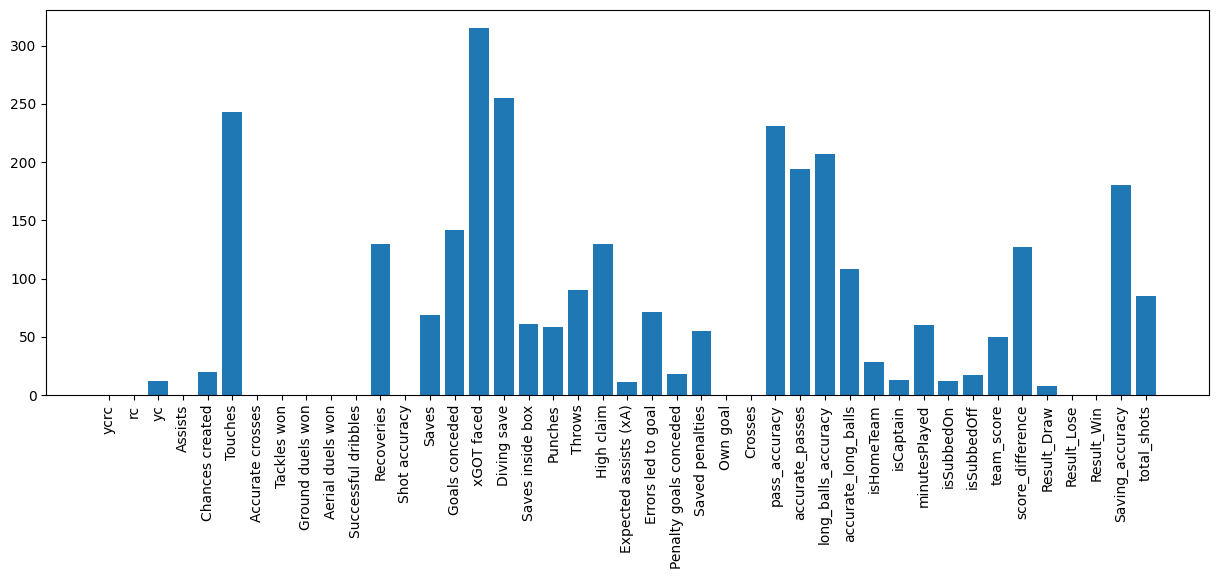

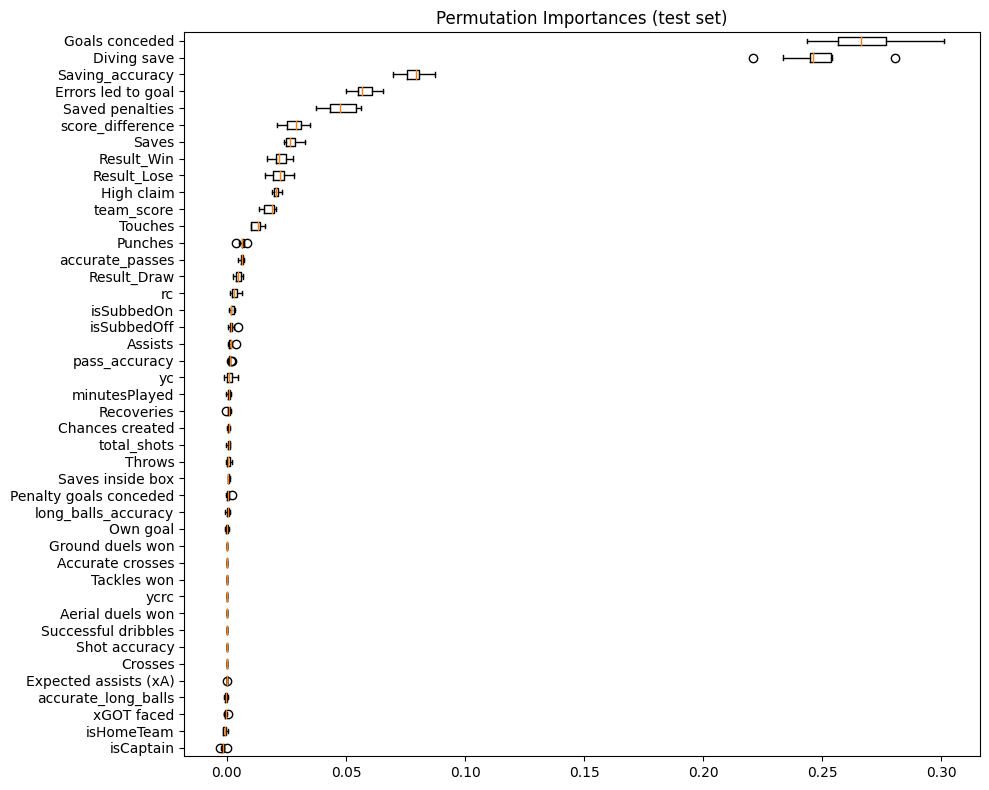

In [ ]:
plt.figure(figsize=(15,5))
plt.bar(X_train.columns,BRidge._final_estimator.coef_)
x = plt.xticks(rotation="vertical")

plt.figure(figsize=(15,5))
plt.bar(X_train.columns,LgbR._final_estimator.feature_importances_)
x = plt.xticks(rotation="vertical")



from sklearn.inspection import permutation_importance
# calculate feature importances using permutation importance
result = permutation_importance(svr, X_test, y_test, n_repeats=10, random_state=42)

# plot the feature importances


fig, ax = plt.subplots(figsize=(10, 8))
sorted_idx = result.importances_mean.argsort()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [ ]:
columns_to_drop = (BRidge._final_estimator.coef_ < 0.03) & (LgbR._final_estimator.feature_importances_ < 20)

X_train.columns[columns_to_drop]


Index(['ycrc', 'rc', 'yc', 'Accurate crosses', 'Tackles won',
       'Ground duels won', 'Aerial duels won', 'Successful dribbles',
       'Shot accuracy', 'Expected assists (xA)', 'Penalty goals conceded',
       'Own goal', 'isCaptain', 'isSubbedOn', 'isSubbedOff', 'Result_Draw',
       'Result_Lose'],
      dtype='object')

## drop some features
### new scores:
    BRidge 0.8911319029851308
    LgbR 0.8832394620045964
    svr 0.8928674716545189

In [ ]:
X_train, X_test, y_train, y_test = split_df(keeper_df.drop(['isCaptain', 'Expected assists (xA)', 'Penalty goals conceded', 'ycrc',
        'Crosses', 'Shot accuracy', 'Accurate crosses', 'Tackles won',
        'Ground duels won', 'Aerial duels won', 'Successful dribbles', 'minutesPlayed', 'Result_Draw'], axis=1))

In [ ]:
pr = make_pipeline(MinMaxScaler())

plt.figure(figsize=(15,12))
BRidge = make_pipeline(pr, BayesianRidge())
BRidge.fit(X_train, y_train)

LgbR = make_pipeline(pr, lgb.LGBMRegressor())
LgbR.fit(X_train, y_train)

svr = make_pipeline(pr, SVR())
svr.fit(X_train, y_train)


print("BRidge", BRidge.score(X_test, y_test))
print("LgbR",LgbR.score(X_test, y_test))
print("svr",svr.score(X_test, y_test))


BRidge 0.8911319029851308
LgbR 0.8832394620045964
svr 0.8928674716545187


<Figure size 1500x1200 with 0 Axes>

## Search the best parameters for the model
    Model: lgbr
    Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__num_leaves': 31}
    Test score: 0.8851
    ============================================================
    Model: svr
    Best parameters: {'model__C': 10, 'model__degree': 2, 'model__kernel': 'poly'}
    Test score: 0.8964
    ============================================================
    Model: bridge
    Best parameters: {'model__alpha_1': 0.0001, 'model__alpha_2': 1e-06, 'model__lambda_1': 1e-06, 'model__lambda_2': 0.0001, 'model__n_iter': 100}
    Test score: 0.8911
    ============================================================


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import r2_score

def r2_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return r2_score(y, y_pred)


# create a pipeline for each model
pipe_lgbm = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', LGBMRegressor())
])

pipe_svr = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', SVR())
])

pipe_bridge = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', BayesianRidge())
])

# set the parameter grids for each model
params_lgbm = {
    'model__learning_rate': [0.1, 0.05, 0.01],
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [3, 6, 9],
    'model__num_leaves': [31, 63, 127]
}

params_svr = {
    'model__C': [0.1, 1, 10],
    'model__kernel': ['linear', 'rbf', 'poly'],
    'model__degree': [2, 3, 4]
}

params_bridge = {
    'model__n_iter': [100, 200, 300],
    'model__alpha_1': [1e-6, 1e-5, 1e-4],
    'model__alpha_2': [1e-6, 1e-5, 1e-4],
    'model__lambda_1': [1e-6, 1e-5, 1e-4],
    'model__lambda_2': [1e-6, 1e-5, 1e-4]
}



# create a list of models and parameter grids to iterate through
models = [pipe_lgbm, pipe_svr, pipe_bridge]
params = [params_lgbm, params_svr, params_bridge]

# create a list to store the best parameters and scores for each model
best_params = []
best_scores = []

grids = []
# iterate through each model and its corresponding parameter grid
for model, param in zip(models, params):
    # create a GridSearchCV object and fit it to the data
    grid = GridSearchCV(model, param, cv=5, n_jobs=-1, scoring=r2_scorer)
    #grid = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=20, cv=5, random_state=42, n_jobs=-1,
    #                     scoring=r2_scorer, return_train_score=True)
    
    grid.fit(X_train, y_train)

    grids.append(grid)

    print(f"Model: {model.__class__.__name__}")
    print(f"Best parameters: {grid.best_params_}")
    print(f"Train score: {grid.best_score_:.4f}")
    print(f"Test score: {grid.best_estimator_.score(X_test, y_test):.4f}")
    print("===" * 20)


Model: Pipeline
Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__num_leaves': 31}
Train score: 0.8637
Test score: 0.8851
Model: Pipeline
Best parameters: {'model__C': 10, 'model__degree': 2, 'model__kernel': 'poly'}
Train score: 0.8793
Test score: 0.8964
Model: Pipeline
Best parameters: {'model__alpha_1': 0.0001, 'model__alpha_2': 1e-06, 'model__lambda_1': 1e-06, 'model__lambda_2': 0.0001, 'model__n_iter': 100}
Train score: 0.8808
Test score: 0.8911


## add new features using PolynomialFeatures
### improved models:
    bridge    0.899811


In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

y = []

pr = make_pipeline(MinMaxScaler(),PolynomialFeatures(2, include_bias=False))
svr = make_pipeline(pr, SVR(**grids[1].best_estimator_.named_steps['model'].get_params()))
svr.fit(X_train, y_train)

LgbR = make_pipeline(pr, lgb.LGBMRegressor(**grids[0].best_estimator_.named_steps['model'].get_params()))
LgbR.fit(X_train, y_train)

BRidge = make_pipeline(pr, BayesianRidge(**grids[2].best_estimator_.named_steps['model'].get_params()))
BRidge.fit(X_train, y_train)

y.append([svr.score(X_test, y_test), LgbR.score(X_test, y_test), BRidge.score(X_test, y_test)])

da = np.array(y).T

In [ ]:
pd.DataFrame(da).T.max().set_axis(["svr", 'lgbr', "bridge"])


svr       0.891462
lgbr      0.878092
bridge    0.899811
dtype: float64

## stacking

final score : 0.902

<Axes: >

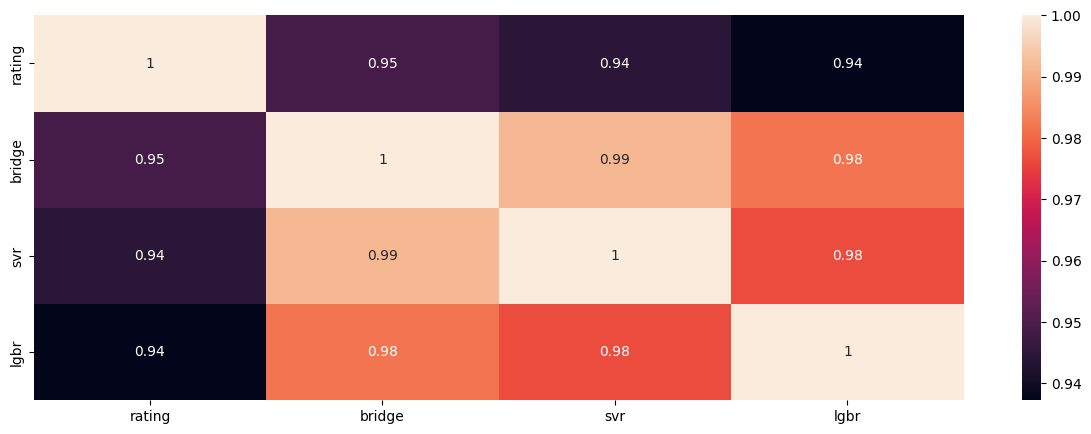

In [ ]:
plt.figure(figsize=(15,5))

sns.heatmap(pd.DataFrame(np.array([y_test, BRidge.predict(X_test),svr.predict(X_test), LgbR.predict(X_test)]).T, columns = ["rating", "bridge","svr","lgbr"]).corr(), annot=True)


In [ ]:
from sklearn.ensemble import StackingRegressor
X_train, X_test, y_train, y_test = split_df(keeper_df.drop(['isCaptain', 'Expected assists (xA)', 'Penalty goals conceded', 'yc',
        'Crosses', 'Shot accuracy', 'Accurate crosses', 'Tackles won',
        'Ground duels won', 'Aerial duels won', 'Successful dribbles', 'minutesPlayed', 'Result_Draw'], axis=1))

LgbR = make_pipeline(MinMaxScaler(), lgb.LGBMRegressor(**grids[0].best_estimator_.named_steps['model'].get_params()))
svr = make_pipeline(MinMaxScaler(), SVR(**grids[1].best_estimator_.named_steps['model'].get_params()))

pr = make_pipeline(MinMaxScaler(),PolynomialFeatures(2, include_bias=False))
BRidge = make_pipeline(pr, BayesianRidge(**grids[2].best_estimator_.named_steps['model'].get_params()))
        
        
regressors1 = [('LgbR',LgbR),('SVR', svr), ('BRidge', BRidge)]#

regressors2 = [('BRidge', BRidge),('SVR', svr)]

stregr1 = StackingRegressor(estimators=regressors1, 
                           final_estimator=make_pipeline(MinMaxScaler(), Ridge()))

stregr2 = StackingRegressor(estimators=regressors2, 
                           final_estimator=make_pipeline(MinMaxScaler(), Ridge()))

stregr = StackingRegressor(estimators=[("stregr1",stregr1), ("stregr2", stregr2)], 
                           final_estimator=make_pipeline(MinMaxScaler(), Ridge()))

LgbR.fit(X_train, y_train)

svr.fit(X_train, y_train)
BRidge.fit(X_train, y_train)

stregr.fit(X_train, y_train)

StackingRegressor(estimators=[('stregr1',
                               StackingRegressor(estimators=[('LgbR',
                                                              Pipeline(steps=[('minmaxscaler',
                                                                               MinMaxScaler()),
                                                                              ('lgbmregressor',
                                                                               LGBMRegressor(max_depth=3,
                                                                                             n_estimators=200))])),
                                                             ('SVR',
                                                              Pipeline(steps=[('minmaxscaler',
                                                                               MinMaxScaler()),
                                                                              ('svr',
                                                                               SVR(C=10,
                                                                                   degree=2,
                                                                                   kernel='poly'))])),
                                                             ('BRidge',
                                                              Pipeline(steps=[('pipeline',
                                                                               Pipeline(steps=[('min...
                                                                                                PolynomialFeatures(include_bias=False))])),
                                                                              ('bayesianridge',
                                                                               BayesianRidge(alpha_1=0.0001,
                                                                                             lambda_2=0.0001,
                                                                                             n_iter=100))])),
                                                             ('SVR',
                                                              Pipeline(steps=[('minmaxscaler',
                                                                               MinMaxScaler()),
                                                                              ('svr',
                                                                               SVR(C=10,
                                                                                   degree=2,
                                                                                   kernel='poly'))]))],
                                                 final_estimator=Pipeline(steps=[('minmaxscaler',
                                                                                  MinMaxScaler()),
                                                                                 ('ridge',
                                                                                  Ridge())])))],
                  final_estimator=Pipeline(steps=[('minmaxscaler',
                                                   MinMaxScaler()),
                                                  ('ridge', Ridge())]))

In [ ]:
stregr.score(X_test, y_test)

0.9021989148803871

# Defender
best score : 91.5%

In [ ]:
def preprocess_defender(df):
    defender = df.query(f"role == 'Defender'")
    means = defender.isna().mean()
    c_todrop = means[means == 1.0].index.tolist()
    defender = defender.drop(c_todrop, axis=1)
    defender = defender.drop(["role"], axis=1)
    return defender.astype(float).fillna(0)

In [ ]:
defender_df = preprocess_defender(players_cdf)

## improving the score
 **current score:** <br>

    XGBR 0.8922021207629116
    LgbR 0.9019969620857008
    svr 0.9101147904869306

- our df contains 54 feature which takes time for training we need to drop some columns<br>

**comments :** <br>
- The models perform well in predicting ratings that are greater than 6, but their performance is relatively poorer for ratings that are less than 6. Further analysis could be conducted to identify the reasons for this discrepancy and to explore the possibility of including additional features to enhance the models' predictive capabilities.<br>

**after droping 16 columns :**

    XGBR 0.894782351359342
    LgbR 0.9030153548866814
    svr 0.9052304103059032

**using randomizeSearchCV**

    Model: LgbR
    Best parameters: {'model__num_leaves': 63, 'model__n_estimators': 100, 'model__max_depth': 9, 'model__learning_rate': 0.1}
    Test score: 0.9028
    ============================================================
    Model: XGBR
    Best parameters: {'model__subsample': 0.8, 'model__n_estimators': 200, 'model__max_depth': 7, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.8}
    Test score: 0.9077
    ============================================================

**with PolynomialFeatures:**

    svr [0.90444441]
    lgbr [0.89312364]
    XGBRegressor [0.89667349]
  
**using stacking:**

    0.915
    

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge,Lasso, BayesianRidge, LassoLarsIC,ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
import lightgbm as lgb
from sklearn.svm import SVR

## selecting models

GradientBoostingRegressor 	R2 score: 0.8783740167683745
Ridge 	R2 score: 0.8544816175916584
XGBRegressor 	R2 score: 0.8922021207629116
BayesianRidge 	R2 score: 0.8542897509658565
lgbR 	R2 score: 0.9019969620857008
SVR 	R2 score: 0.9101147904869307


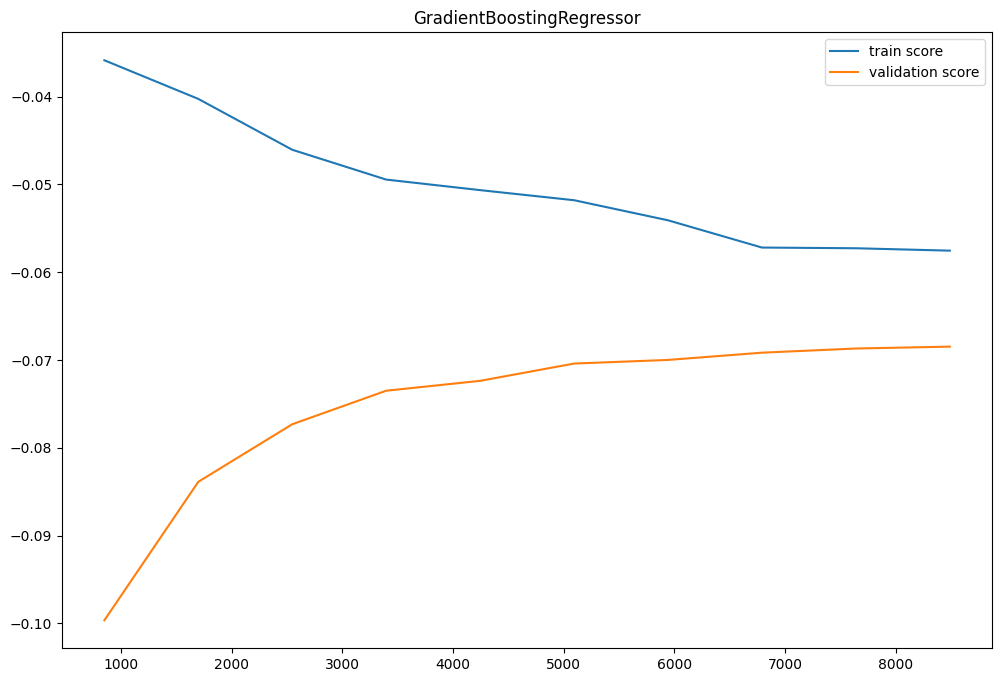

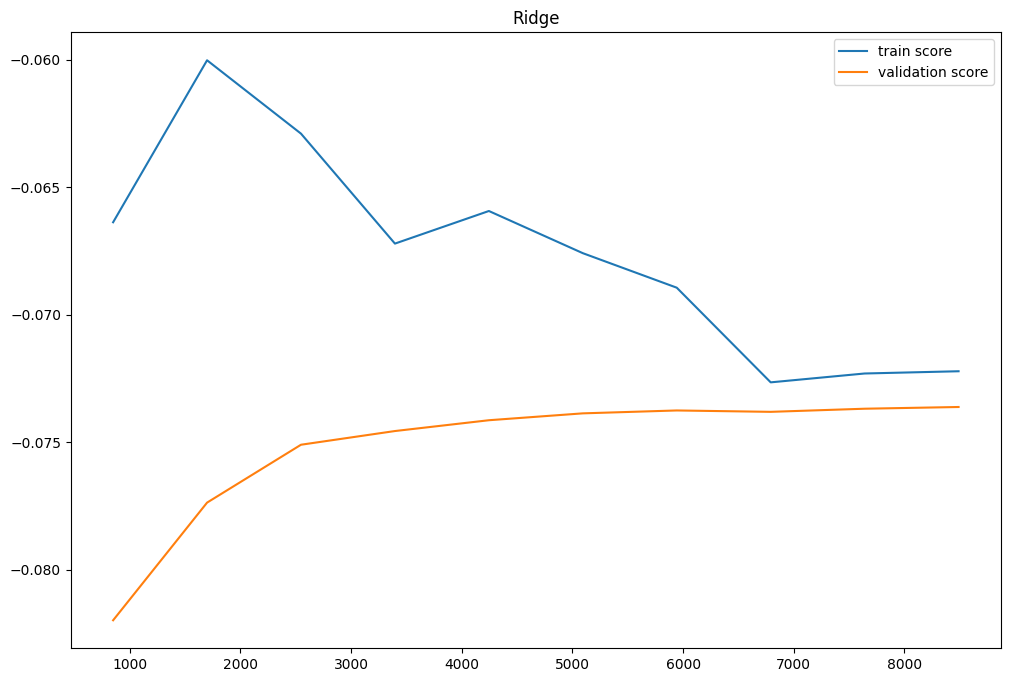

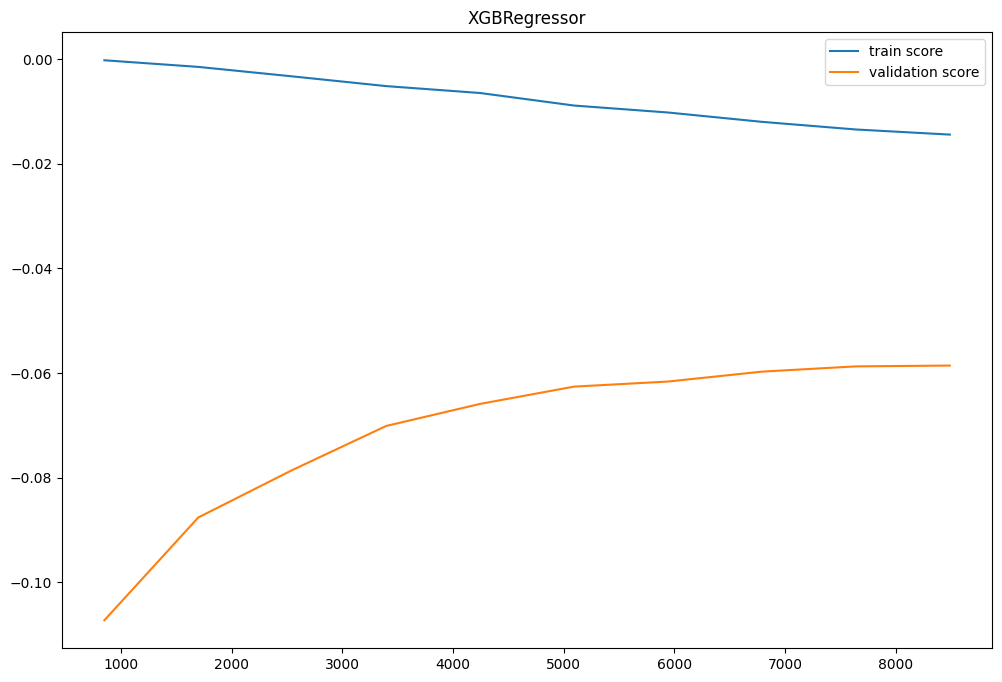

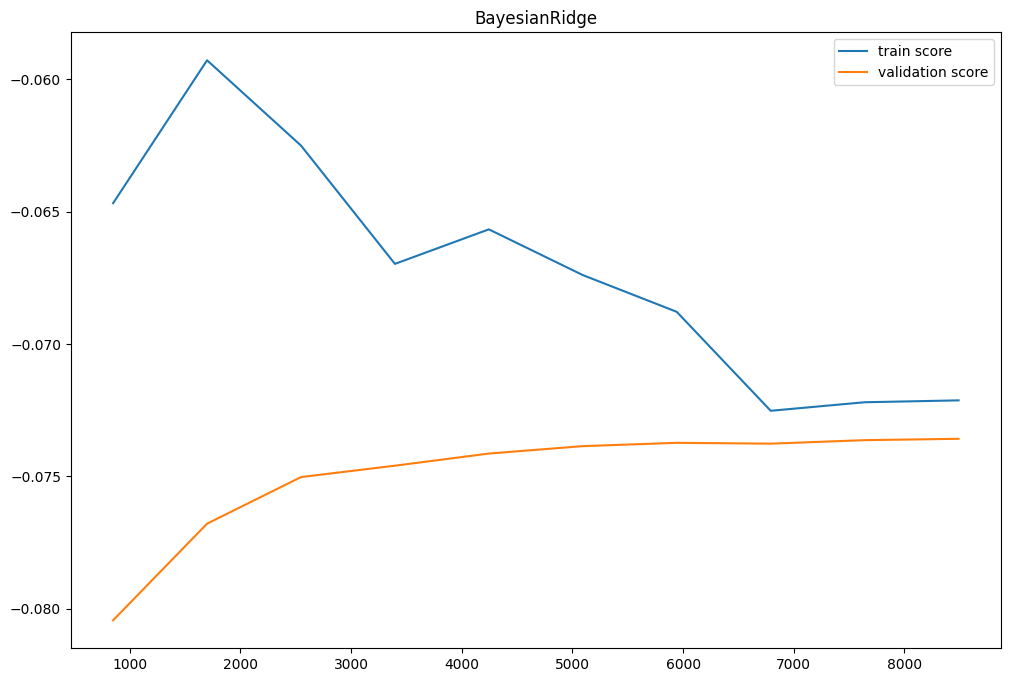

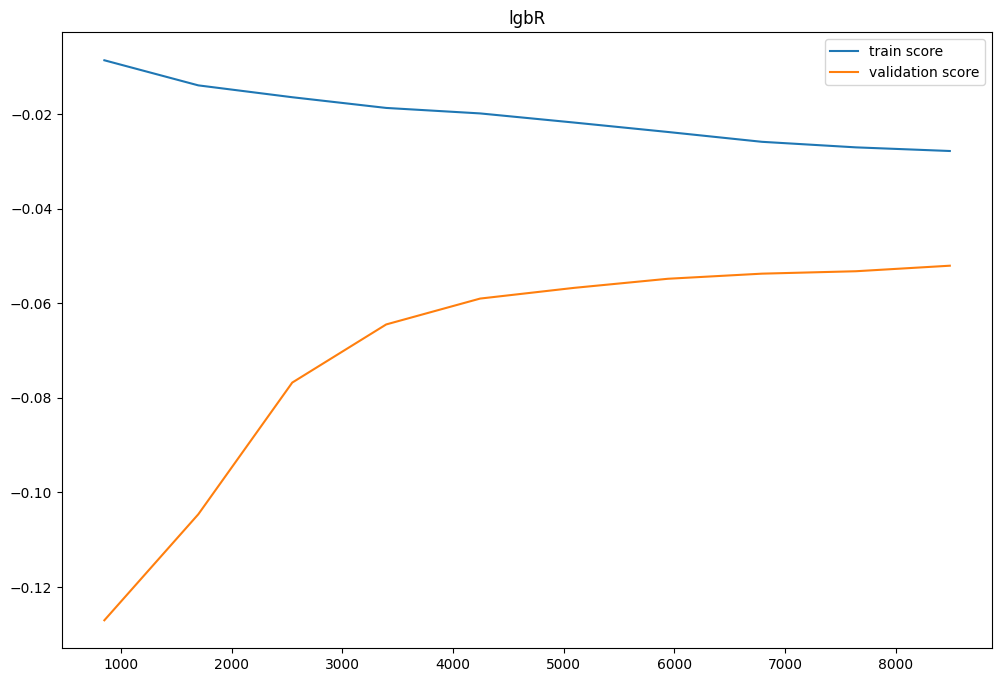

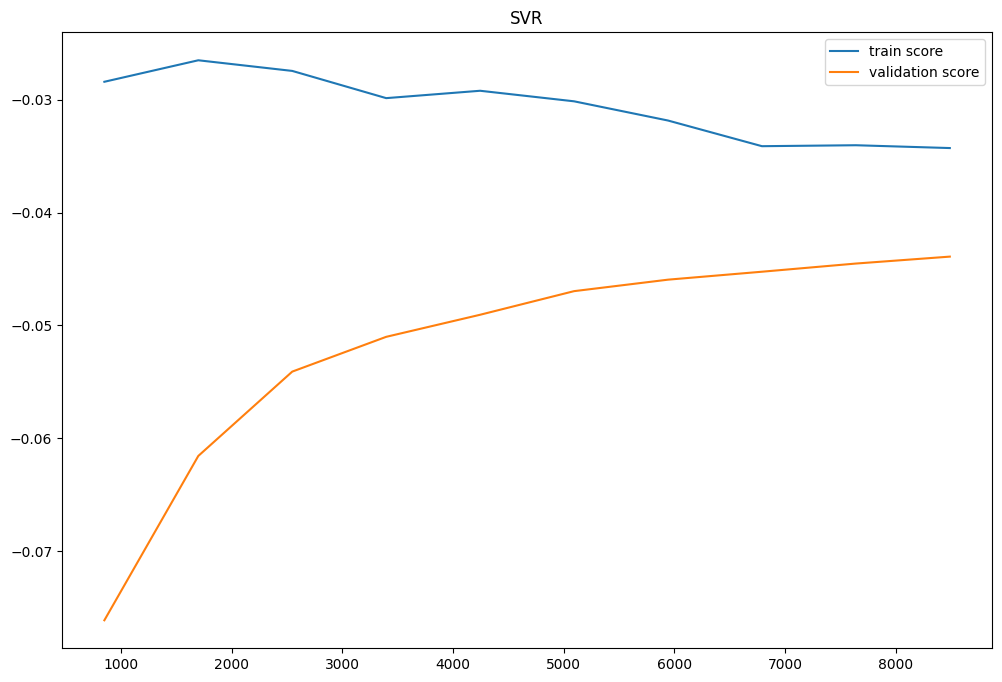

In [ ]:
regressors = {
    "GradientBoostingRegressor" : GradientBoostingRegressor(),
    "Ridge" : Ridge(),
    "XGBRegressor" : XGBRegressor(),
    "BayesianRidge" : BayesianRidge(),
    "lgbR" : lgb.LGBMRegressor(),
    "SVR":SVR()
}

X_train, X_test, y_train, y_test = split_df(defender_df)
for model_name in regressors:
    model = make_pipeline(MinMaxScaler(), regressors[model_name])
    evaluation(model, X_train, y_train, X_test, y_test)
    plt.title(model_name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(model_name, "\tR2 score:", r2_score(y_test, y_pred))

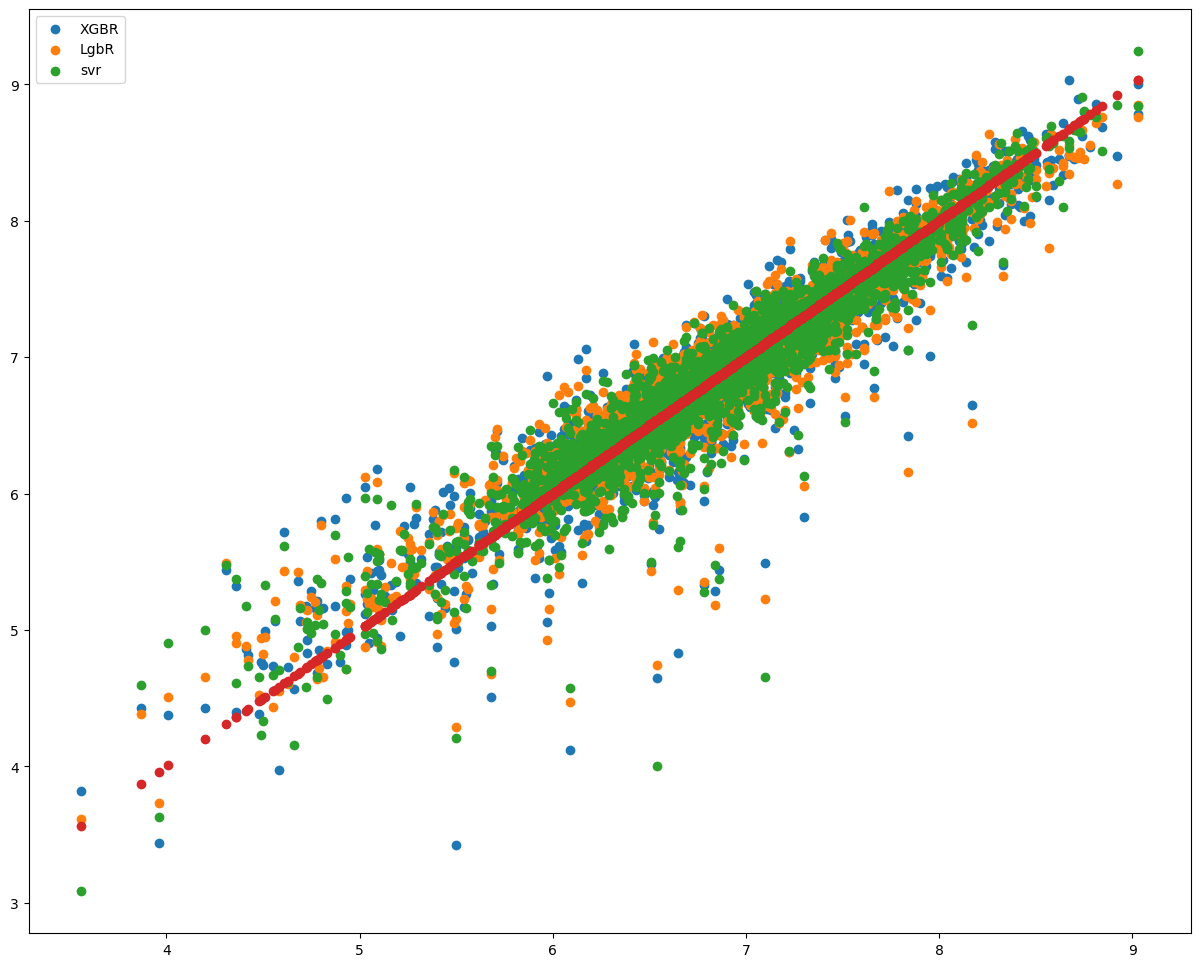

In [ ]:

X_train, X_test, y_train, y_test = split_df(defender_df)
pr = make_pipeline(MinMaxScaler())

plt.figure(figsize=(15,12))

XGBR = make_pipeline(pr, XGBRegressor())
XGBR.fit(X_train, y_train)
plt.scatter(y_test, XGBR.predict(X_test), label="XGBR")

LgbR = make_pipeline(pr, lgb.LGBMRegressor())
LgbR.fit(X_train, y_train)
plt.scatter(y_test, LgbR.predict(X_test), label="LgbR")

svr = make_pipeline(pr, SVR())
svr.fit(X_train, y_train)
plt.scatter(y_test, svr.predict(X_test), label="svr")

plt.scatter(y_test, y_test)
plt.legend()



In [ ]:
print("XGBR" ,XGBR.score(X_test, y_test))
print("LgbR",LgbR.score(X_test, y_test))
print("svr",svr.score(X_test, y_test))


XGBR 0.8922021207629116
LgbR 0.9019969620857008
svr 0.9101147904869307


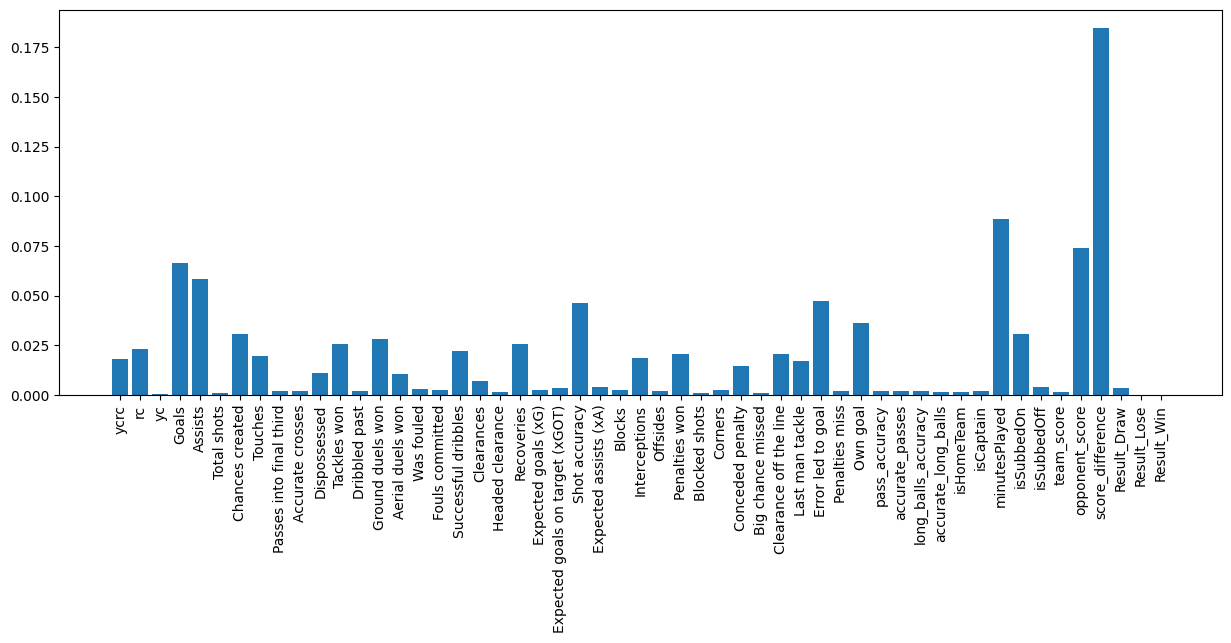

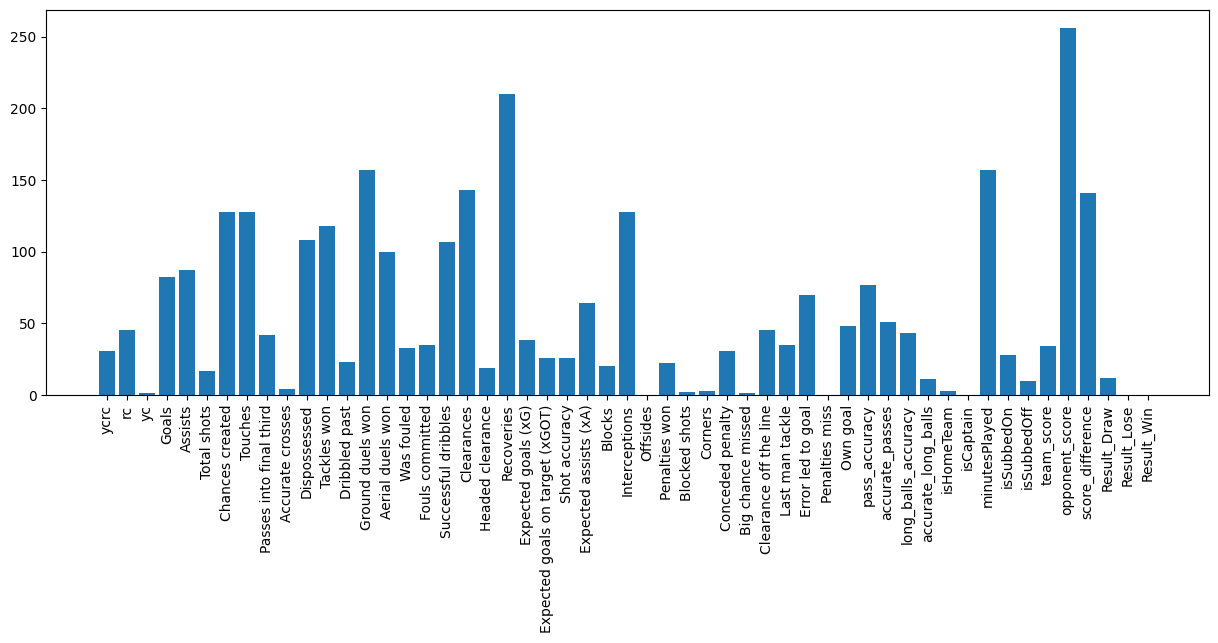

In [ ]:

plt.figure(figsize=(15,5))
plt.bar(X_train.columns,XGBR._final_estimator.feature_importances_)
x = plt.xticks(rotation="vertical")
plt.figure(figsize=(15,5))
plt.bar(X_train.columns,LgbR._final_estimator.feature_importances_)
x = plt.xticks(rotation="vertical")




In [ ]:
columns_to_drop = (np.abs(XGBR._final_estimator.feature_importances_) < 0.01) & (LgbR._final_estimator.feature_importances_ < 20)
c_to_drop = X_train.columns[columns_to_drop]

X_train.columns[columns_to_drop]

Index(['yc', 'Total shots', 'Accurate crosses', 'Headed clearance', 'Offsides',
       'Blocked shots', 'Corners', 'Big chance missed', 'Penalties miss',
       'accurate_long_balls', 'isHomeTeam', 'isCaptain', 'isSubbedOff',
       'Result_Draw', 'Result_Lose', 'Result_Win'],
      dtype='object')

In [ ]:
X_train, X_test, y_train, y_test = split_df(defender_df.drop(c_to_drop, axis=1))

In [ ]:
pr = make_pipeline(MinMaxScaler())

XGBR = make_pipeline(pr, XGBRegressor())
XGBR.fit(X_train, y_train)

LgbR = make_pipeline(pr, lgb.LGBMRegressor())
LgbR.fit(X_train, y_train)

svr = make_pipeline(pr, SVR())
svr.fit(X_train, y_train)


print("XGBR" ,XGBR.score(X_test, y_test))
print("LgbR",LgbR.score(X_test, y_test))
print("svr",svr.score(X_test, y_test))


XGBR 0.894782351359342
LgbR 0.9030153548866814
svr 0.9052304103059031


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

def r2_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return r2_score(y, y_pred)


# create a pipeline for each model
pipe_lgbm = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', LGBMRegressor())
])

pipe_svr = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', SVR())
])

pipe_xgb = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', XGBRegressor())
])

# set the parameter grids for each model
params_lgbm = {
    'model__learning_rate': [0.1, 0.05, 0.01],
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [3, 6, 9],
    'model__num_leaves': [31, 63, 127]
}

params_svr = {
    'model__C': [0.1, 1, 10],
    'model__kernel': ['linear', 'rbf'],
    'model__degree': [2, 3, 4]
}

params_xgb = {
    'model__learning_rate': [0.1, 0.01, 0.001],
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [3, 5, 7],
    'model__subsample': [0.8, 0.9, 1],
    'model__colsample_bytree': [0.8, 0.9, 1]
}


# create a list of models and parameter grids to iterate through
models = [pipe_lgbm, pipe_xgb]
params = [params_lgbm, params_xgb]

# create a list to store the best parameters and scores for each model
best_params = []
best_scores = []

grids = []
# iterate through each model and its corresponding parameter grid
for model, param in zip(models, params):
    grid = RandomizedSearchCV(estimator=model, param_distributions=param, n_iter=10, cv=5, random_state=42, n_jobs=-1,
                         scoring=r2_scorer, return_train_score=True)
    
    grid.fit(X_train, y_train)

    grids.append(grid)

    print(f"Model: {model.__class__.__name__}")
    print(f"Best parameters: {grid.best_params_}")
    print(f"Train score: {grid.best_score_:.4f}")
    print(f"Test score: {grid.best_estimator_.score(X_test, y_test):.4f}")
    print("===" * 20)


Model: Pipeline
Best parameters: {'model__num_leaves': 63, 'model__n_estimators': 100, 'model__max_depth': 9, 'model__learning_rate': 0.1}
Train score: 0.9036
Test score: 0.9028
Model: Pipeline
Best parameters: {'model__subsample': 0.8, 'model__n_estimators': 200, 'model__max_depth': 7, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.8}
Train score: 0.9084
Test score: 0.9077


In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

y = []
labels = ["svr", "lgbr" , "XGBRegressor"]

pr = make_pipeline(MinMaxScaler(),PolynomialFeatures(2, include_bias=False))

svr = make_pipeline(pr, SVR())
svr.fit(X_train, y_train)

LgbR = make_pipeline(pr, lgb.LGBMRegressor(**grids[0].best_estimator_.named_steps['model'].get_params()))
LgbR.fit(X_train, y_train)

XGBR = make_pipeline(pr, XGBRegressor(**grids[1].best_estimator_.named_steps['model'].get_params()))
XGBR.fit(X_train, y_train)


y.append([svr.score(X_test, y_test), LgbR.score(X_test, y_test), XGBR.score(X_test, y_test)])

da = np.array(y).T

In [ ]:
for model, v in zip(labels,da):
    print(model, v)

svr [0.90444441]
lgbr [0.89312364]
XGBRegressor [0.89667349]


In [ ]:
from sklearn.ensemble import StackingRegressor


X_train, X_test, y_train, y_test = split_df(defender_df.drop(c_to_drop, axis=1))

pr = make_pipeline(MinMaxScaler())

LgbR = make_pipeline(pr, lgb.LGBMRegressor(**grids[0].best_estimator_.named_steps['model'].get_params()))
svr = make_pipeline(pr, SVR())
XGBR = make_pipeline(pr, XGBRegressor(**grids[1].best_estimator_.named_steps['model'].get_params()))

        
        
regressors1 = [('XGBR', XGBR),('SVR', svr), ('LgbR',LgbR)]#

stregr1 = StackingRegressor(estimators=regressors1, 
                           final_estimator=make_pipeline(MinMaxScaler(), Ridge()))


stregr1.fit(X_train, y_train)

StackingRegressor(estimators=[('XGBR',
                               Pipeline(steps=[('pipeline',
                                                Pipeline(steps=[('minmaxscaler',
                                                                 MinMaxScaler())])),
                                               ('xgbregressor',
                                                XGBRegressor(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=0.8,
                                                             early_stopping_rounds=None,
                                                             enable_categorical=False,
                                                             eval_metric=None,
                                                             feature_types=None,
                                                             gamma=...
                                                             random_state=None, ...))])),
                              ('SVR',
                               Pipeline(steps=[('pipeline',
                                                Pipeline(steps=[('minmaxscaler',
                                                                 MinMaxScaler())])),
                                               ('svr', SVR())])),
                              ('LgbR',
                               Pipeline(steps=[('pipeline',
                                                Pipeline(steps=[('minmaxscaler',
                                                                 MinMaxScaler())])),
                                               ('lgbmregressor',
                                                LGBMRegressor(max_depth=9,
                                                              num_leaves=63))]))],
                  final_estimator=Pipeline(steps=[('minmaxscaler',
                                                   MinMaxScaler()),
                                                  ('ridge', Ridge())]))

In [ ]:
stregr1.score(X_test, y_test)

0.9150070339094275

# Midfielder
best score 93.12%

In [ ]:
def preprocess_midfielder(df):
    defender = df.query(f"role == 'Midfielder'")
    means = defender.isna().mean()
    c_todrop = means[means == 1.0].index.tolist()
    defender = defender.drop(c_todrop, axis=1)
    defender = defender.drop(["role"], axis=1)
    return defender.astype(float).fillna(0)

In [ ]:
midfielder_df = preprocess_midfielder(players_cdf)

## improving the score
 **current score:** <br>

    XGBRegressor 	R2 score: 0.9107214913287417
    lgbR 	R2 score: 0.9188764466949731
    SVR 	R2 score: 0.9281407634943313
- our df contains 55 feature which takes time for training we need to drop some columns<br>

**after droping 21 columns :**

    XGBR 0.9127296058228214
    LgbR 0.9185983687520235
    svr 0.9241166471284423

**using randomizeSearchCV**

    Model: lgbr
    Best parameters: {'model__num_leaves': 63, 'model__n_estimators': 100, 'model__max_depth': 9, 'model__learning_rate': 0.1}
    Test score: 0.9178
    ============================================================
    Model: xgboost
    Best parameters: {'model__subsample': 0.8, 'model__n_estimators': 200, 'model__max_depth': 7, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.8}
    Test score: 0.9216

**with PolynomialFeatures:**

    svr [0.92139843]
    lgbr [0.91642147]
    XGBRegressor [0.91755714]
  
**using stacking:**

    0.9312


## selecting models

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge,Lasso, BayesianRidge, LassoLarsIC,ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
import lightgbm as lgb
from sklearn.svm import SVR

GradientBoostingRegressor 	R2 score: 0.8957054604811119
Ridge 	R2 score: 0.9096095732371409
XGBRegressor 	R2 score: 0.9107214913287417
BayesianRidge 	R2 score: 0.9096853810479679
lgbR 	R2 score: 0.9188764466949731
SVR 	R2 score: 0.9281407634943313


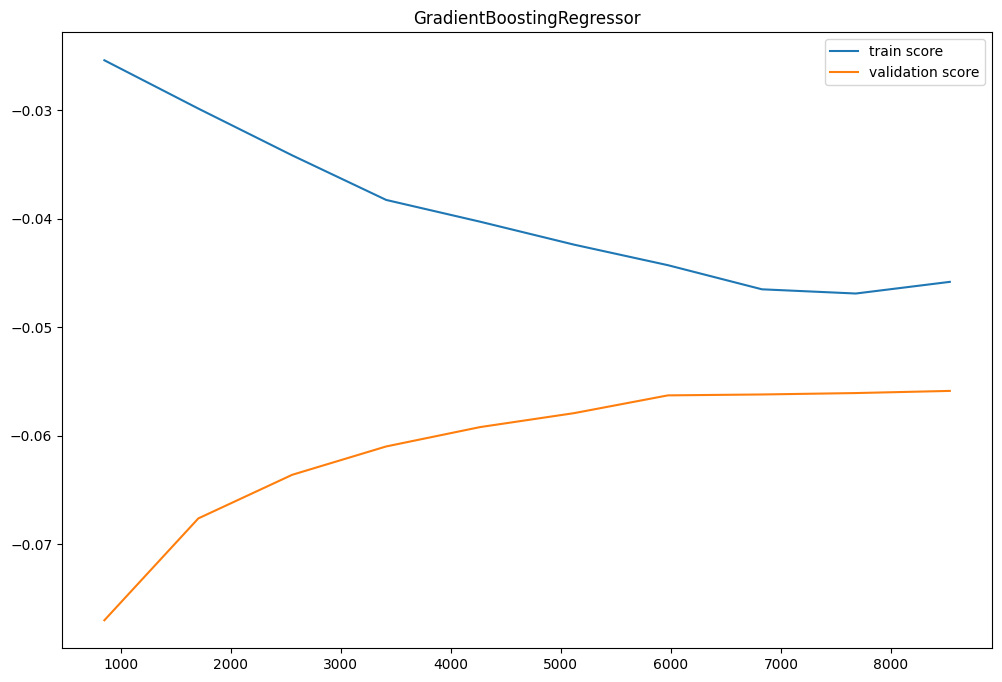

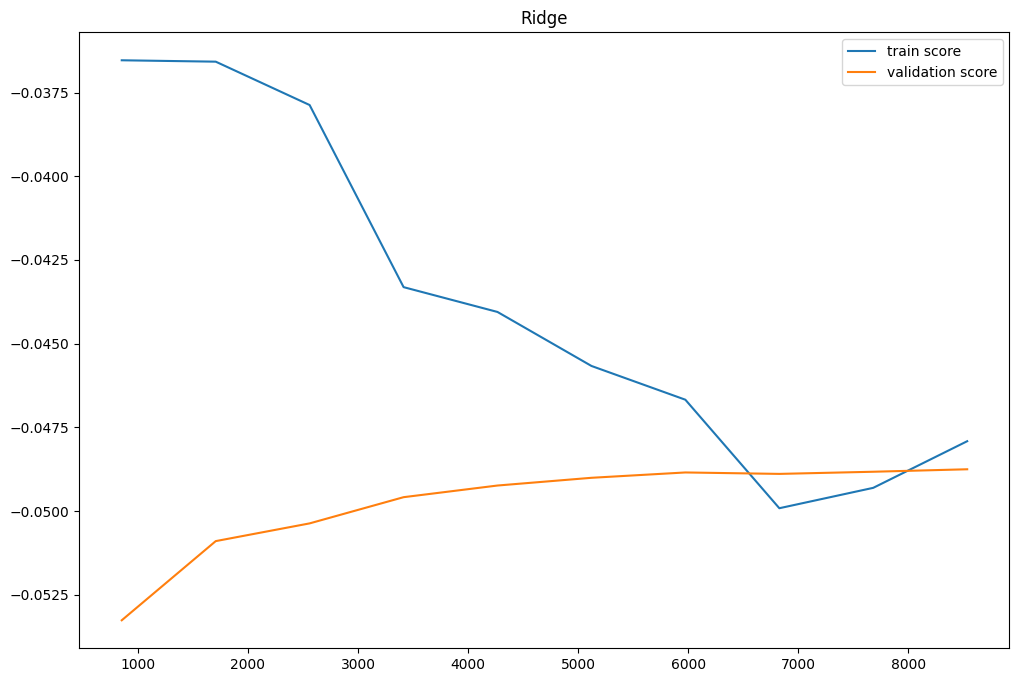

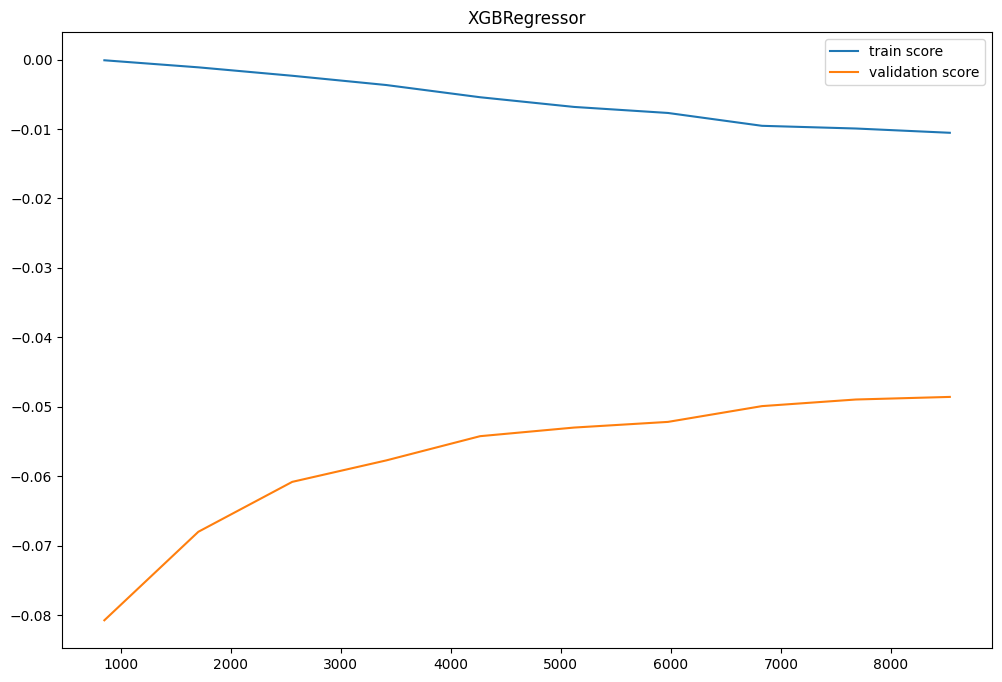

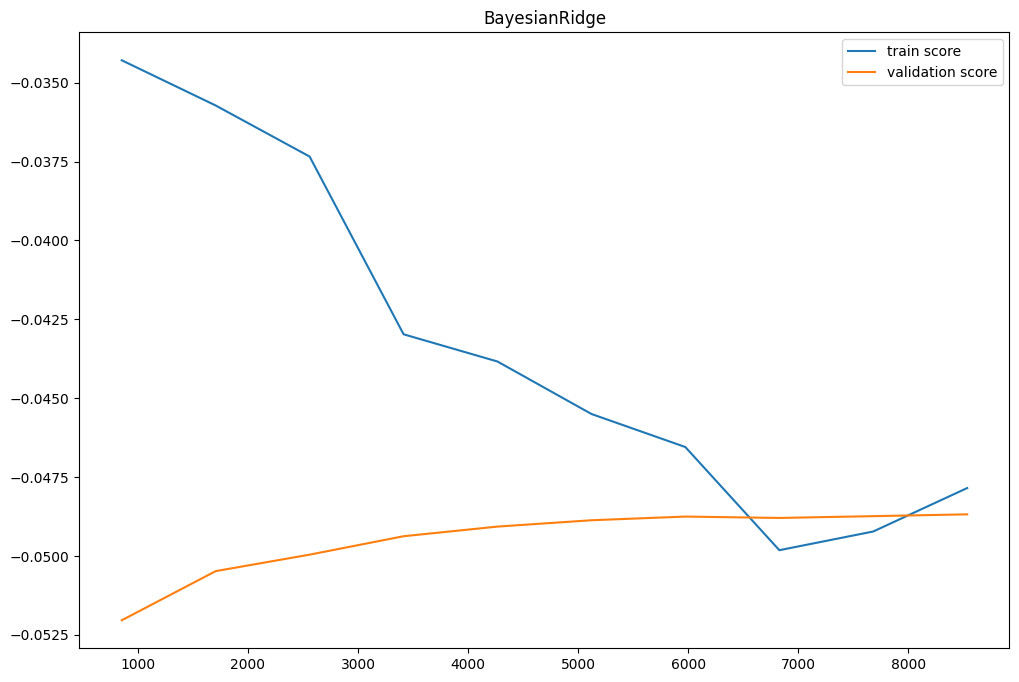

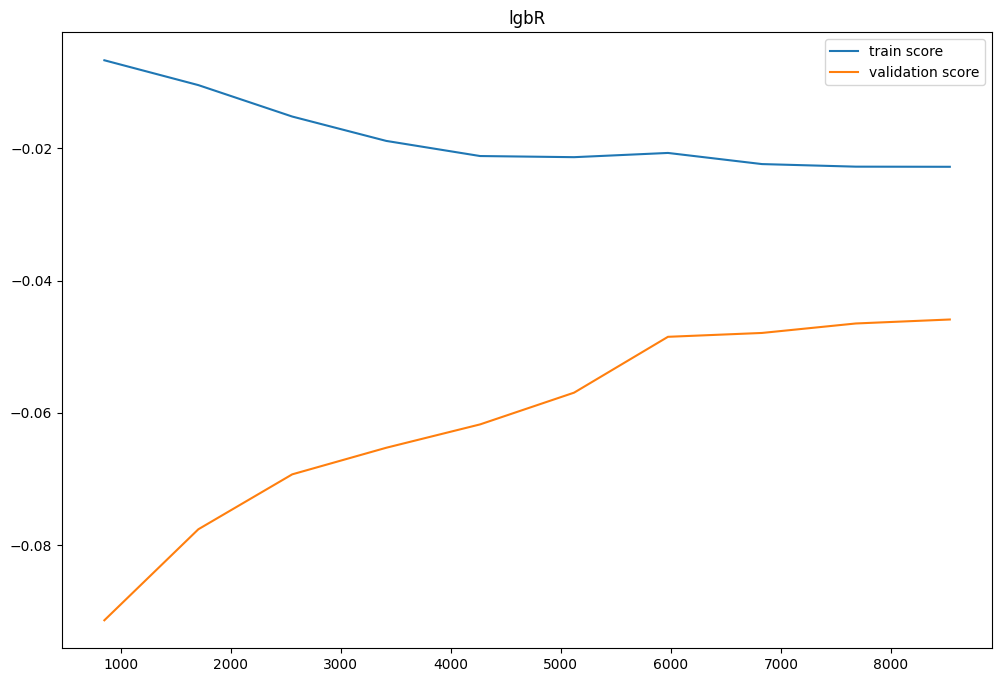

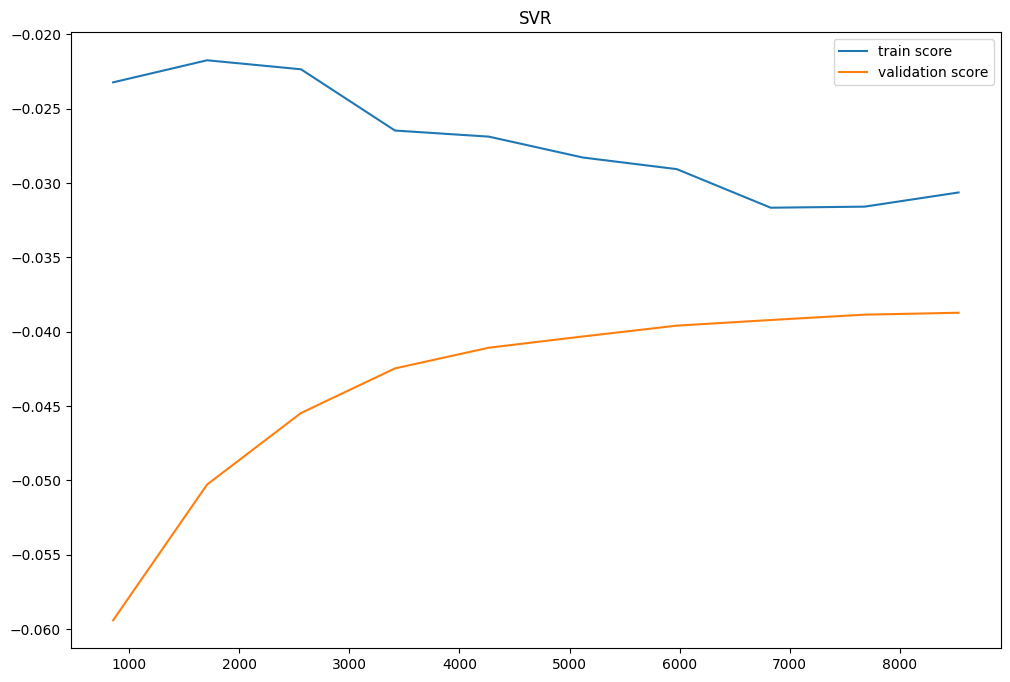

In [ ]:
regressors = {
    "GradientBoostingRegressor" : GradientBoostingRegressor(),
    "Ridge" : Ridge(),
    "XGBRegressor" : XGBRegressor(),
    "BayesianRidge" : BayesianRidge(),
    "lgbR" : lgb.LGBMRegressor(),
    "SVR":SVR()
}

X_train, X_test, y_train, y_test = split_df(midfielder_df)
for model_name in regressors:
    model = make_pipeline(MinMaxScaler(), regressors[model_name])
    evaluation(model, X_train, y_train, X_test, y_test)
    plt.title(model_name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(model_name, "\tR2 score:", r2_score(y_test, y_pred))

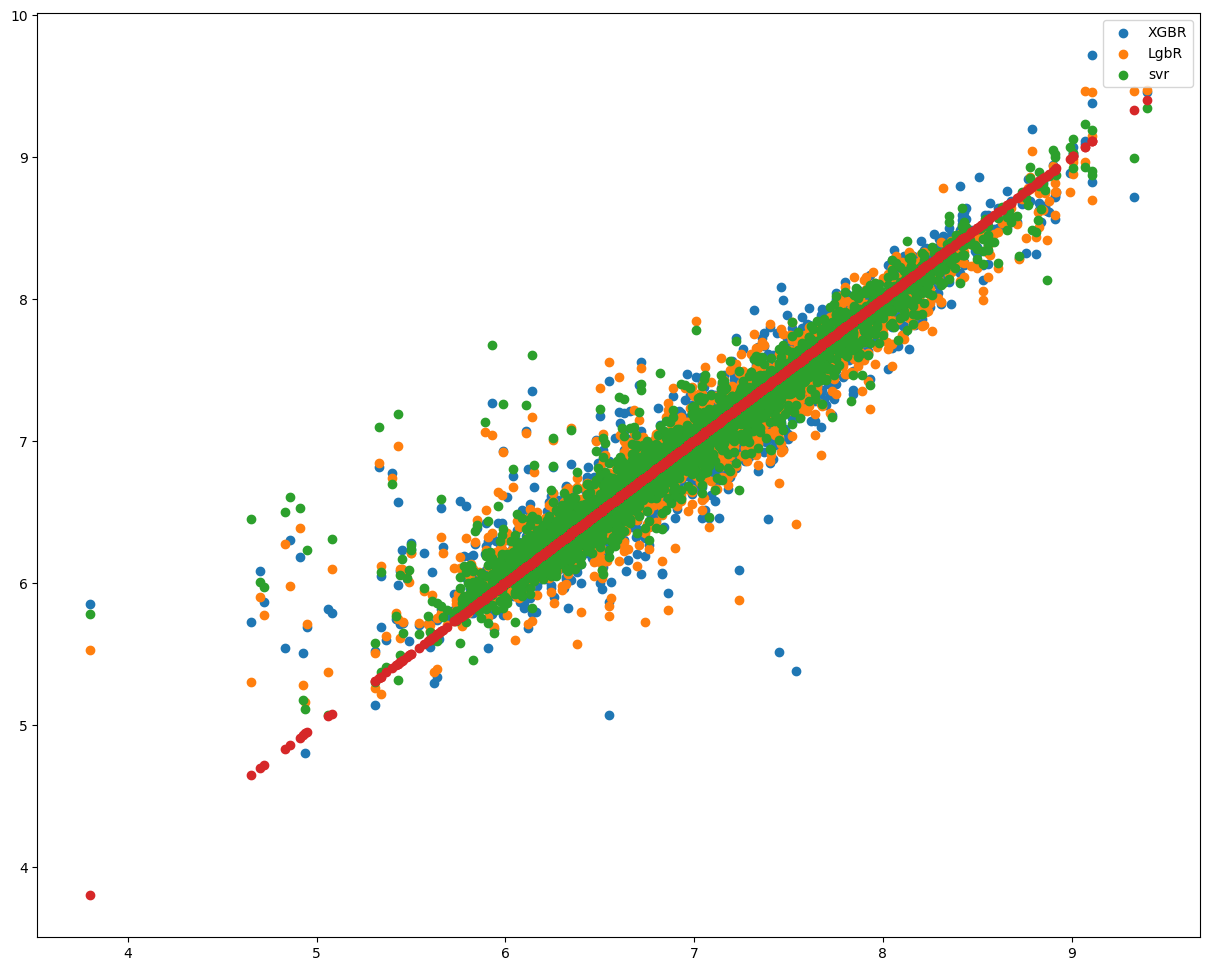

In [ ]:

X_train, X_test, y_train, y_test = split_df(midfielder_df)

pr = make_pipeline(MinMaxScaler())

plt.figure(figsize=(15,12))

XGBR = make_pipeline(pr, XGBRegressor())
XGBR.fit(X_train, y_train)
plt.scatter(y_test, XGBR.predict(X_test), label="XGBR")

LgbR = make_pipeline(pr, lgb.LGBMRegressor())
LgbR.fit(X_train, y_train)
plt.scatter(y_test, LgbR.predict(X_test), label="LgbR")

svr = make_pipeline(pr, SVR())
svr.fit(X_train, y_train)
plt.scatter(y_test, svr.predict(X_test), label="svr")

plt.scatter(y_test, y_test)
plt.legend()



In [ ]:
print("XGBR" ,XGBR.score(X_test, y_test))
print("LgbR",LgbR.score(X_test, y_test))
print("svr",svr.score(X_test, y_test))


XGBR 0.9107214913287417
LgbR 0.9188764466949731
svr 0.9281407634943313


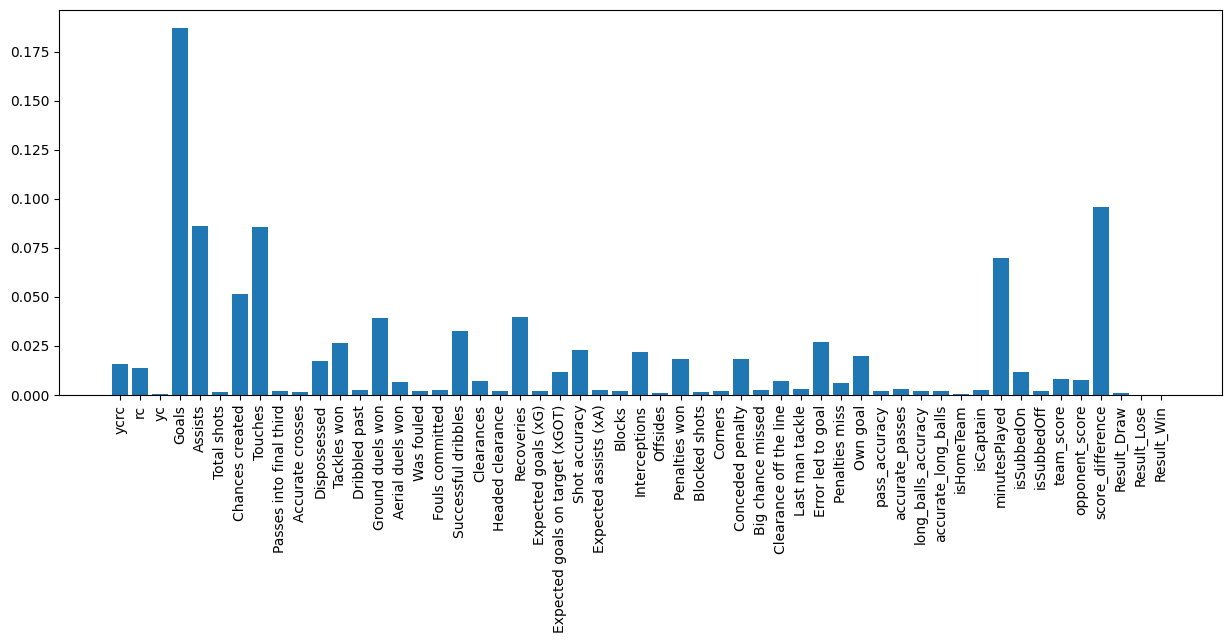

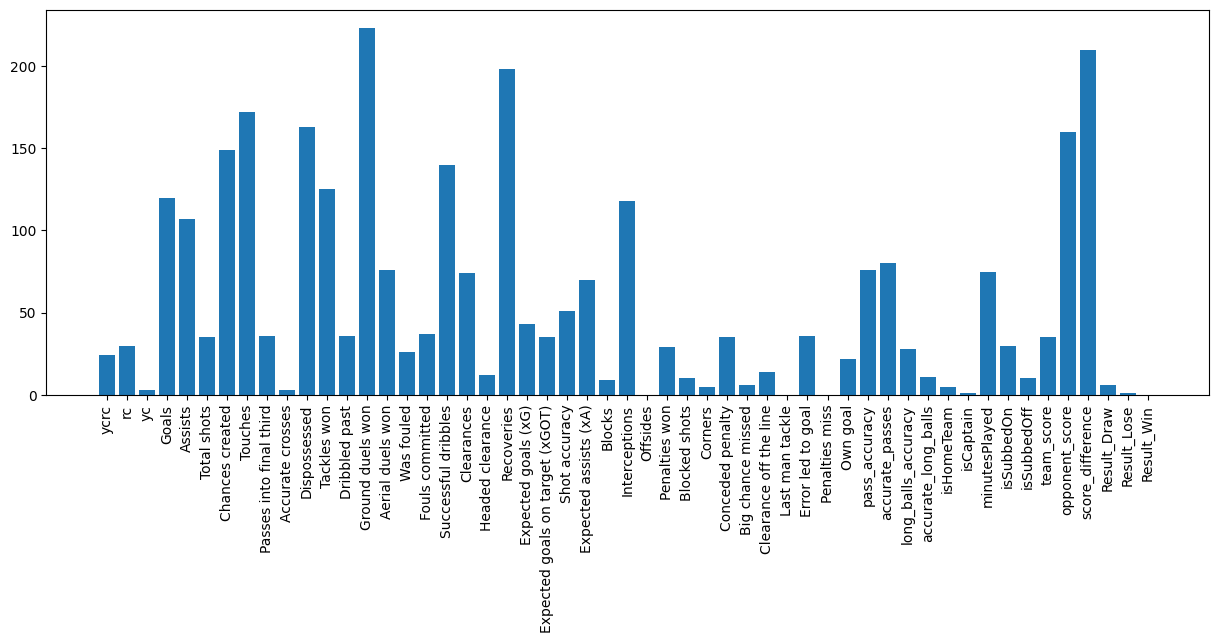

In [ ]:
plt.figure(figsize=(15,5))
plt.bar(X_train.columns,XGBR._final_estimator.feature_importances_)
x = plt.xticks(rotation="vertical")
plt.figure(figsize=(15,5))
plt.bar(X_train.columns,LgbR._final_estimator.feature_importances_)
x = plt.xticks(rotation="vertical")




In [ ]:
columns_to_drop = (np.abs(XGBR._final_estimator.feature_importances_) < 0.0125) & (LgbR._final_estimator.feature_importances_ < 30)

c_to_drop = X_train.columns[columns_to_drop]

In [ ]:
X_train, X_test, y_train, y_test = split_df(midfielder_df.drop(c_to_drop, axis=1))

In [ ]:
pr = make_pipeline(MinMaxScaler())

XGBR = make_pipeline(pr, XGBRegressor())
XGBR.fit(X_train, y_train)
print("XGBR" ,XGBR.score(X_test, y_test))

LgbR = make_pipeline(pr, lgb.LGBMRegressor())
LgbR.fit(X_train, y_train)
print("LgbR",LgbR.score(X_test, y_test))

svr = make_pipeline(pr, SVR())
svr.fit(X_train, y_train)
print("svr",svr.score(X_test, y_test))

XGBR 0.9127296058228214
LgbR 0.9185983687520235
svr 0.9241166471284423


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score

def r2_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return r2_score(y, y_pred)


# create a pipeline for each model
pipe_lgbm = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', lgb.LGBMRegressor())
])

pipe_svr = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', SVR())
])

pipe_xgb = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', XGBRegressor())
])

# set the parameter grids for each model
params_lgbm = {
    'model__learning_rate': [0.1, 0.05, 0.01],
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [3, 6, 9],
    'model__num_leaves': [31, 63, 127]
}

params_svr = {
    'model__C': [0.1, 1, 10],
    'model__kernel': ['linear', 'rbf'],
    'model__degree': [2, 3, 4]
}

params_xgb = {
    'model__learning_rate': [0.1, 0.01, 0.001],
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [3, 5, 7],
    'model__subsample': [0.8, 0.9, 1],
    'model__colsample_bytree': [0.8, 0.9, 1]
}


# create a list of models and parameter grids to iterate through
models = [pipe_lgbm, pipe_xgb]
params = [params_lgbm, params_xgb]

# create a list to store the best parameters and scores for each model
best_params = []
best_scores = []

grids = []
# iterate through each model and its corresponding parameter grid
for model, param in zip(models, params):
    grid = RandomizedSearchCV(estimator=model, param_distributions=param, n_iter=10, cv=5, random_state=42, n_jobs=-1,
                         scoring=r2_scorer, return_train_score=True)
    
    grid.fit(X_train, y_train)

    grids.append(grid)

    print(f"Model: {model.__class__.__name__}")
    print(f"Best parameters: {grid.best_params_}")
    print(f"Train score: {grid.best_score_:.4f}")
    print(f"Test score: {grid.best_estimator_.score(X_test, y_test):.4f}")
    print("===" * 20)


Model: Pipeline
Best parameters: {'model__num_leaves': 63, 'model__n_estimators': 100, 'model__max_depth': 9, 'model__learning_rate': 0.1}
Train score: 0.9130
Test score: 0.9178
Model: Pipeline
Best parameters: {'model__subsample': 0.8, 'model__n_estimators': 200, 'model__max_depth': 7, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.8}
Train score: 0.9208
Test score: 0.9216


In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline


y = []
labels = ["svr", "lgbr" , "XGBRegressor"]

pr = make_pipeline(MinMaxScaler(),PolynomialFeatures(2, include_bias=False))

svr = make_pipeline(pr, SVR())
svr.fit(X_train, y_train)

LgbR = make_pipeline(pr, lgb.LGBMRegressor(**grids[0].best_estimator_.named_steps['model'].get_params()))
LgbR.fit(X_train, y_train)

XGBR = make_pipeline(pr, XGBRegressor(**grids[1].best_estimator_.named_steps['model'].get_params()))
XGBR.fit(X_train, y_train)


y.append([svr.score(X_test, y_test), LgbR.score(X_test, y_test), XGBR.score(X_test, y_test)])

da = np.array(y).T

In [ ]:
for model, v in zip(labels,da):
    print(model, v)

svr [0.92139843]
lgbr [0.91642147]
XGBRegressor [0.91755714]


In [ ]:
from sklearn.ensemble import StackingRegressor


#X_train, X_test, y_train, y_test = split_df(midfielder_df.drop(X_train[columns_to_drop], axis=1))

pr = make_pipeline(MinMaxScaler(),PolynomialFeatures(2, include_bias=False))

LgbR = make_pipeline(MinMaxScaler(), lgb.LGBMRegressor(**grids[0].best_estimator_.named_steps['model'].get_params()))
svr = make_pipeline(MinMaxScaler(), SVR())
XGBR = make_pipeline(MinMaxScaler(), XGBRegressor(**grids[1].best_estimator_.named_steps['model'].get_params()))
        
        
regressors1 = [('XGBR', XGBR),('SVR', svr), ('LgbR',LgbR)]#

stregr1 = StackingRegressor(estimators=regressors1, 
                           final_estimator=make_pipeline(MinMaxScaler(), Ridge()))


stregr1.fit(X_train, y_train)

StackingRegressor(estimators=[('XGBR',
                               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                               ('xgbregressor',
                                                XGBRegressor(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=0.8,
                                                             early_stopping_rounds=None,
                                                             enable_categorical=False,
                                                             eval_metric=None,
                                                             feature_types=None,
                                                             gamma=None,
                                                             gpu_id=None,
                                                             grow_policy=No...
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             predictor=None,
                                                             random_state=None, ...))])),
                              ('SVR',
                               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                               ('svr', SVR())])),
                              ('LgbR',
                               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                               ('lgbmregressor',
                                                LGBMRegressor(max_depth=9,
                                                              num_leaves=63))]))],
                  final_estimator=Pipeline(steps=[('minmaxscaler',
                                                   MinMaxScaler()),
                                                  ('ridge', Ridge())]))

In [ ]:
stregr1.score(X_test, y_test)

0.9312138336082711

# Attacker
best score 97.15%

In [10]:
def preprocess_attacker(df):
    attacker = df.query(f"role == 'Attacker'")
    means = attacker.isna().mean()
    c_todrop = means[means == 1.0].index.tolist()
    attacker = attacker.drop(c_todrop, axis=1)
    attacker = attacker.drop(["role"], axis=1)
    return attacker.astype(float).fillna(0)

In [11]:
attacker_df = preprocess_attacker(players_cdf)

## improving the score
 **current score:** <br>

    XGBRegressor 	R2 score: 0.9584312077574119
    lgbR 	R2 score: 0.9610757470646529
    SVR 	R2 score: 0.9679671508215397

**using randomizeSearchCV**

    Model: lgbr
    Best parameters: {'model__num_leaves': 63, 'model__n_estimators': 1000, 'model__max_depth': 3, 'model__learning_rate': 0.1}
    Test score: 0.9656
    ============================================================
    Model: xgbr
    Best parameters: {'model__n_estimators': 2000, 'model__learning_rate': 0.01}
    Test score: 0.9660
    ============================================================


**with PolynomialFeatures:**

    svr [0.9593922]
    lgbr [0.96453562]
    XGBRegressor [0.96288176]
  
**using stacking:**

    0.9715


In [12]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge,Lasso, BayesianRidge, LassoLarsIC,ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
import lightgbm as lgb
from sklearn.svm import SVR

## selecting models

GradientBoostingRegressor 	R2 score: 0.949775767799445
XGBRegressor 	R2 score: 0.9584312077574119
BayesianRidge 	R2 score: 0.9473166704480734
lgbR 	R2 score: 0.9610757470646529
SVR 	R2 score: 0.9679671508215397


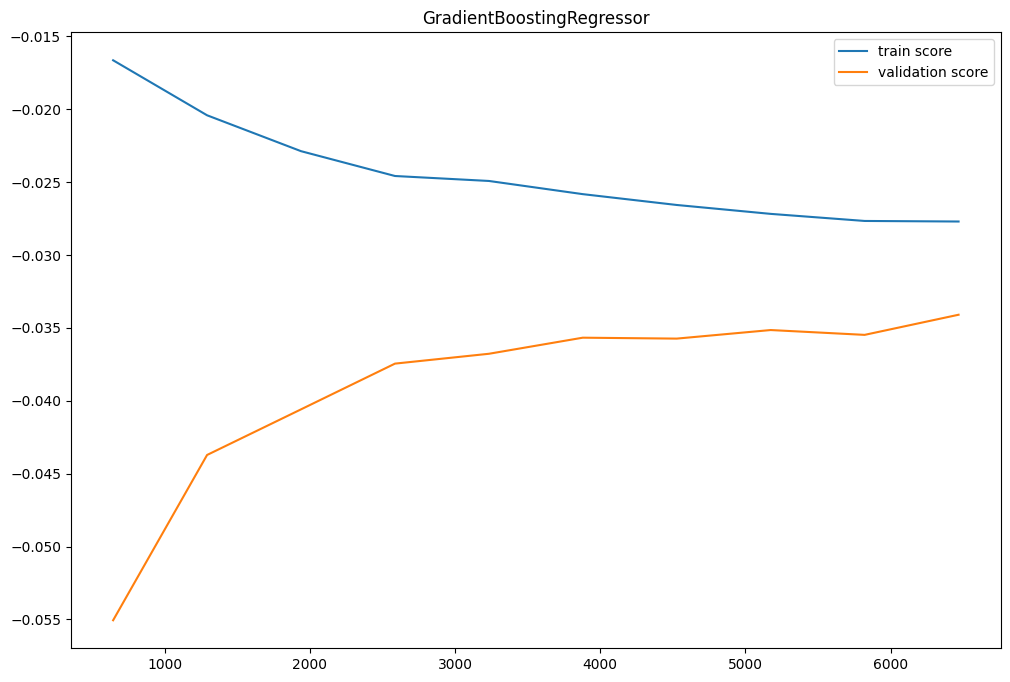

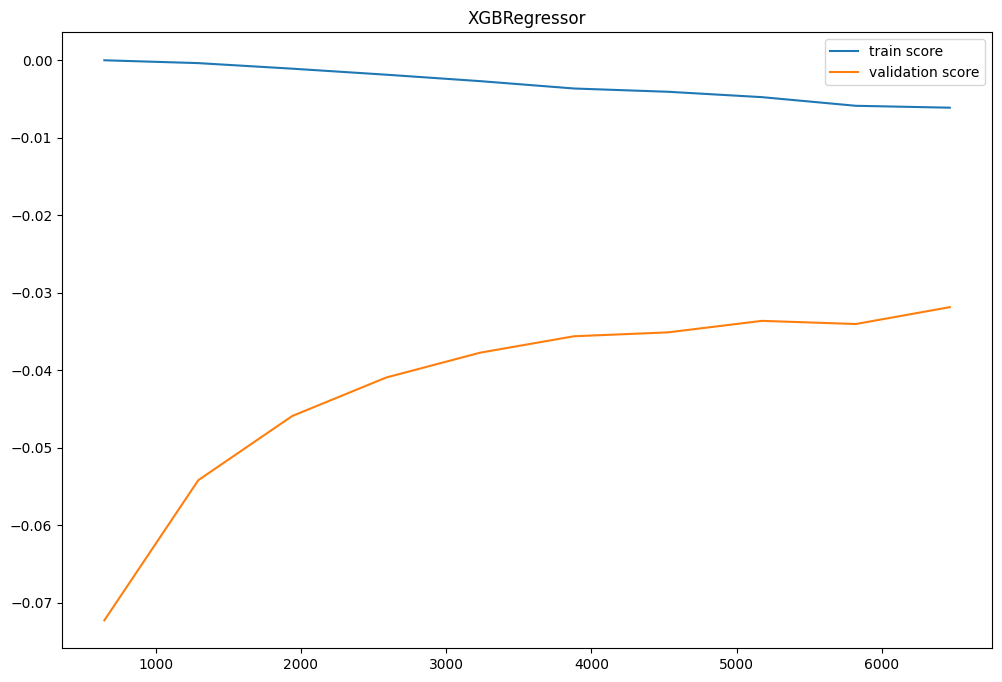

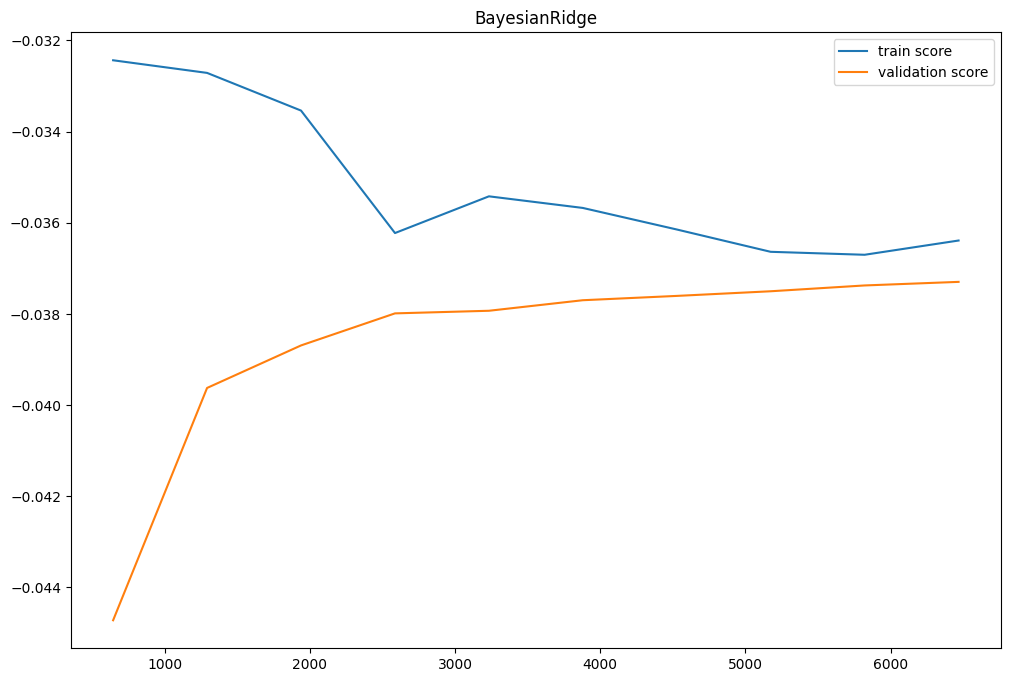

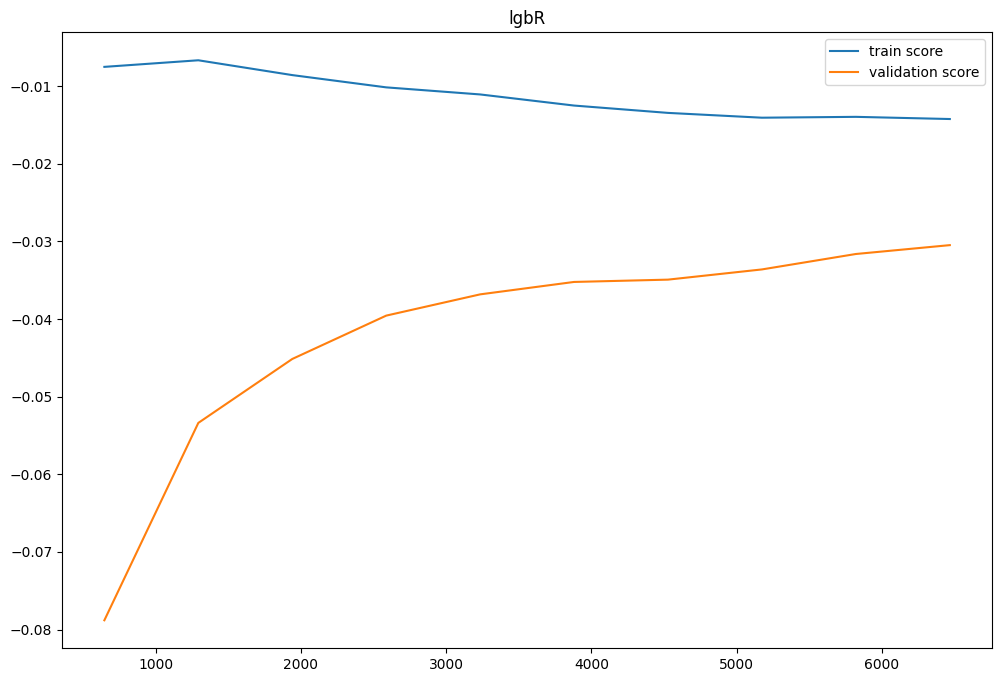

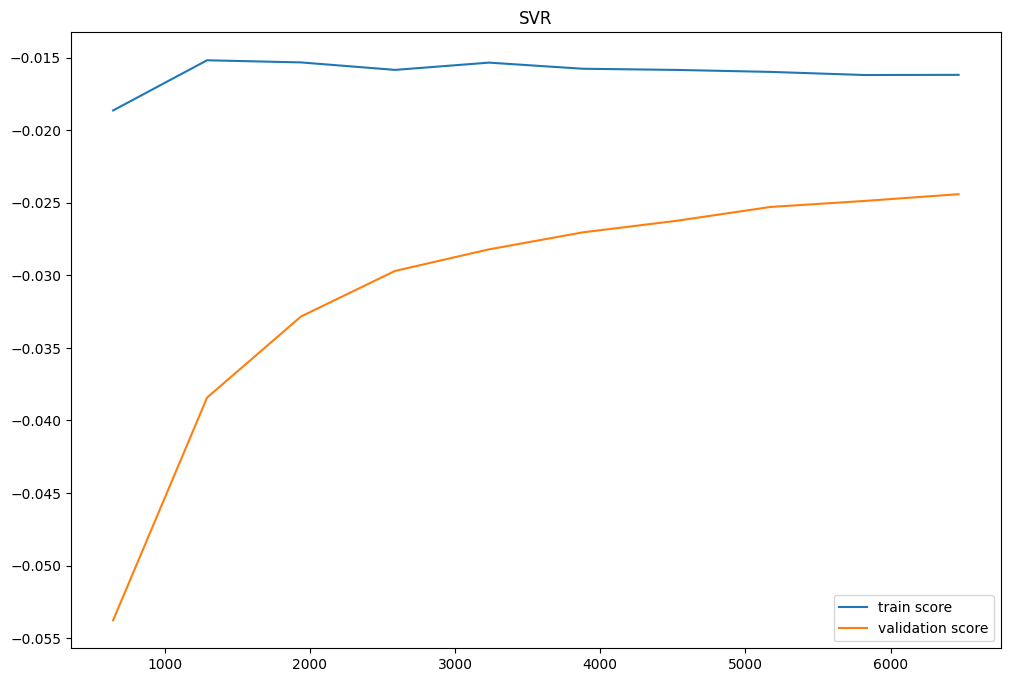

In [13]:
regressors = {
    "GradientBoostingRegressor" : GradientBoostingRegressor(),
    "XGBRegressor" : XGBRegressor(),
    "BayesianRidge" : BayesianRidge(),
    "lgbR" : lgb.LGBMRegressor(),
    "SVR":SVR()
}

X_train, X_test, y_train, y_test = split_df(attacker_df)
for model_name in regressors:
    model = make_pipeline(MinMaxScaler(), regressors[model_name])
    evaluation(model, X_train, y_train, X_test, y_test)
    plt.title(model_name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(model_name, "\tR2 score:", r2_score(y_test, y_pred))

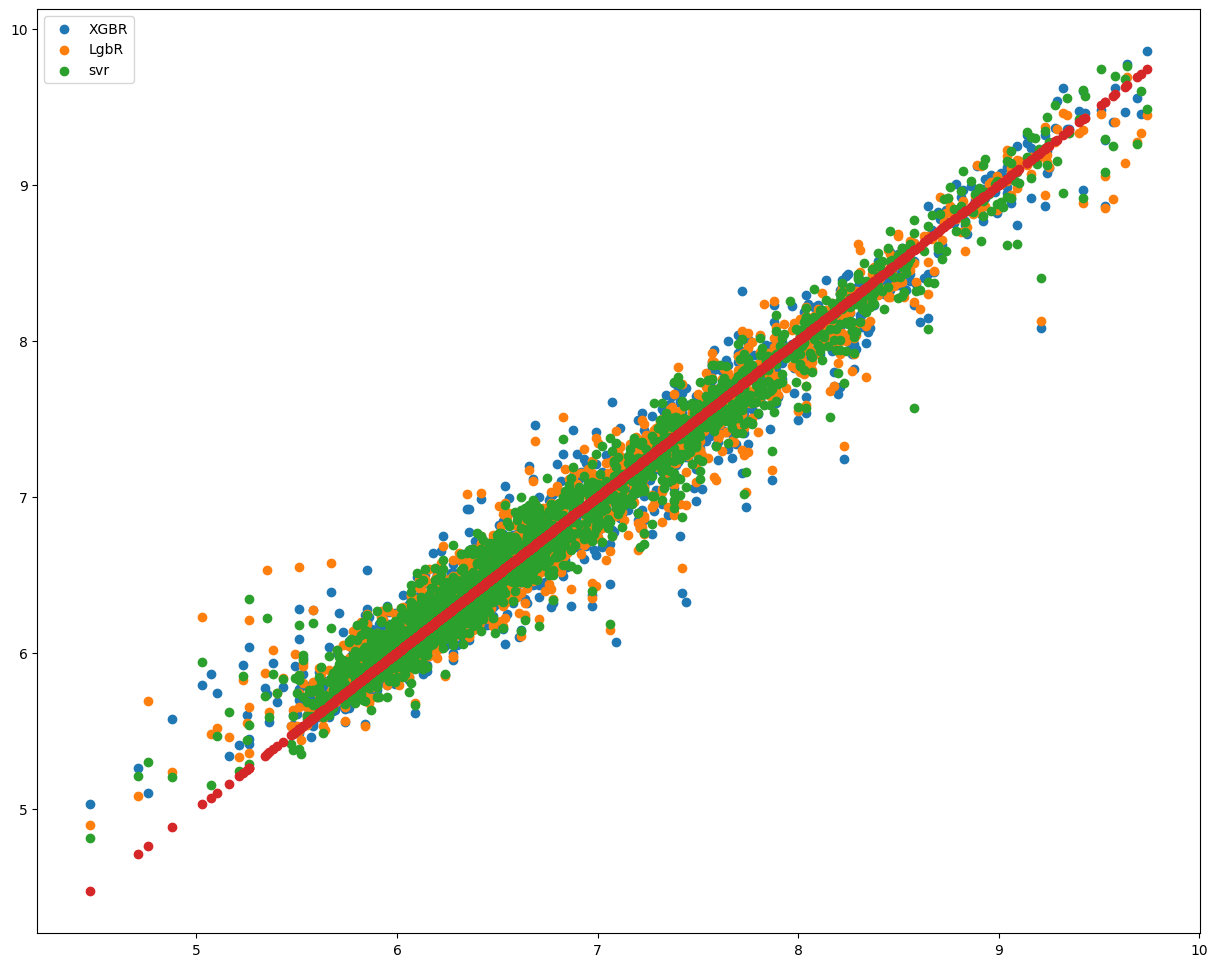

In [14]:
X_train, X_test, y_train, y_test = split_df(attacker_df)

pr = make_pipeline(MinMaxScaler())

plt.figure(figsize=(15,12))

XGBR = make_pipeline(pr, XGBRegressor())
XGBR.fit(X_train, y_train)
plt.scatter(y_test, XGBR.predict(X_test), label="XGBR")

LgbR = make_pipeline(pr, lgb.LGBMRegressor())
LgbR.fit(X_train, y_train)
plt.scatter(y_test, LgbR.predict(X_test), label="LgbR")

svr = make_pipeline(pr, SVR())
svr.fit(X_train, y_train)
plt.scatter(y_test, svr.predict(X_test), label="svr")

plt.scatter(y_test, y_test)
plt.legend()



In [15]:
print("XGBR" ,XGBR.score(X_test, y_test))
print("LgbR",LgbR.score(X_test, y_test))
print("svr",svr.score(X_test, y_test))


XGBR 0.9584312077574119
LgbR 0.9610757470646529
svr 0.9679671508215397


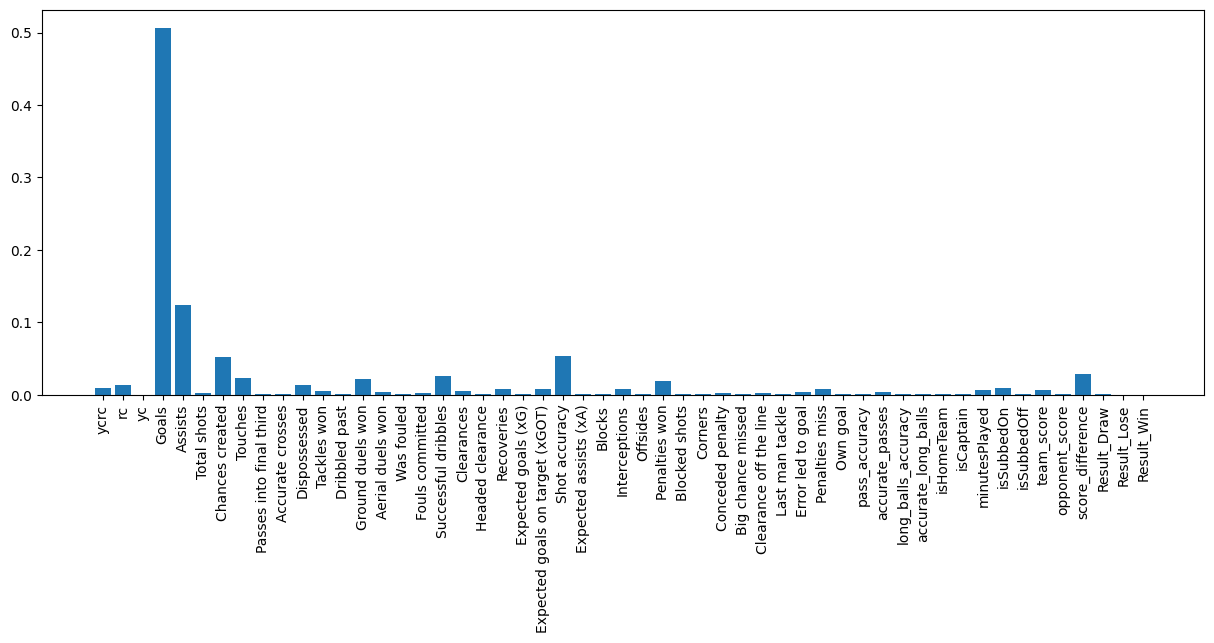

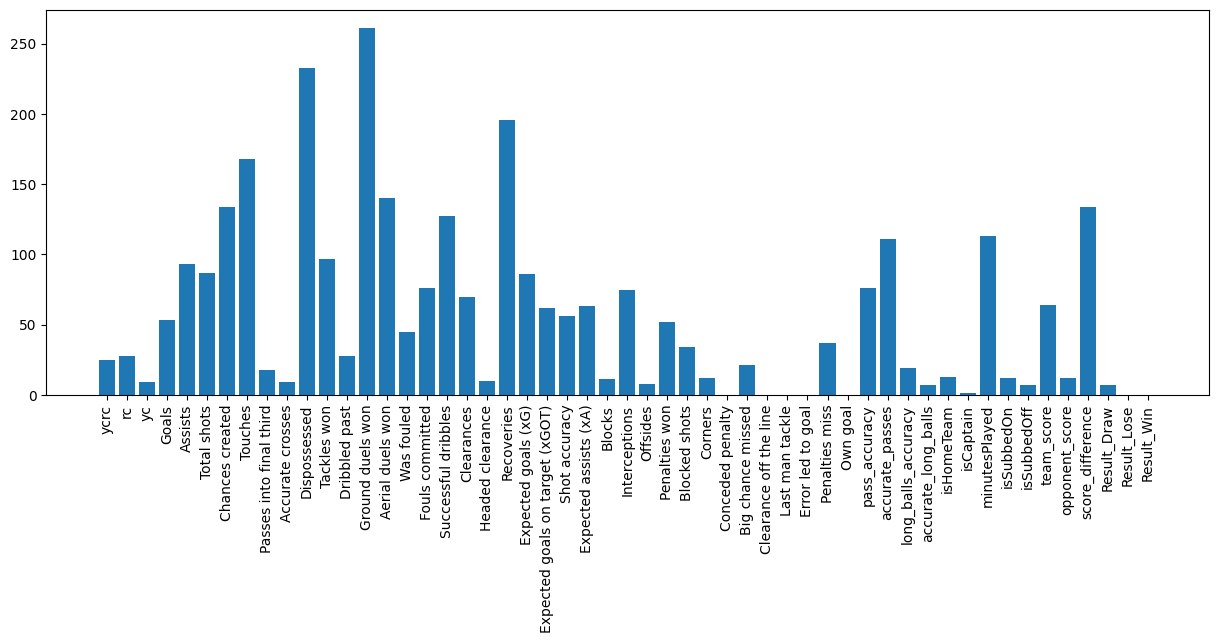

In [16]:
plt.figure(figsize=(15,5))
plt.bar(X_train.columns,XGBR._final_estimator.feature_importances_)
x = plt.xticks(rotation="vertical")

plt.figure(figsize=(15,5))
plt.bar(X_train.columns,LgbR._final_estimator.feature_importances_)
x = plt.xticks(rotation="vertical")




In [17]:
columns_to_drop = (np.abs(XGBR._final_estimator.feature_importances_) < 0.01) & (LgbR._final_estimator.feature_importances_ < 10)

c_to_drop = X_train.columns[columns_to_drop]
c_to_drop

Index(['yc', 'Accurate crosses', 'Offsides', 'Conceded penalty',
       'Clearance off the line', 'Last man tackle', 'Error led to goal',
       'Own goal', 'accurate_long_balls', 'isCaptain', 'isSubbedOff',
       'Result_Draw', 'Result_Lose', 'Result_Win'],
      dtype='object')

In [18]:
X_train, X_test, y_train, y_test = split_df(attacker_df.drop(c_to_drop, axis=1))

In [19]:
pr = make_pipeline(MinMaxScaler())

XGBR = make_pipeline(pr, XGBRegressor())
XGBR.fit(X_train, y_train)
print("XGBR" ,XGBR.score(X_test, y_test))

LgbR = make_pipeline(pr, lgb.LGBMRegressor())
LgbR.fit(X_train, y_train)
print("LgbR",LgbR.score(X_test, y_test))

svr = make_pipeline(pr, SVR())
svr.fit(X_train, y_train)
print("svr",svr.score(X_test, y_test))

XGBR 0.9568232242163612
LgbR 0.9610199819537876
svr 0.9633791063382592


In [20]:
X_train, X_test, y_train, y_test = split_df(attacker_df)

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score

def r2_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return r2_score(y, y_pred)


# create a pipeline for each model
pipe_lgbm = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', lgb.LGBMRegressor())
])

pipe_svr = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', SVR())
])

pipe_gb = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', GradientBoostingRegressor())
])

pipe_xgb = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', XGBRegressor())
])

# set the parameter grids for each model
params_lgbm = {
    'model__learning_rate': [0.1, 0.05, 0.01],
    'model__n_estimators': [100, 1000,2000],
    'model__max_depth': [3, 6, 9],
    'model__num_leaves': [31, 63, 127]
}

params_svr = {
    'model__C': [0.1, 1, 10],
    'model__kernel': ['linear', 'rbf'],
    'model__degree': [2, 3, 4]
}

params_gb = {
    'model__learning_rate': [0.1, 0.01, 0.001],
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [3, 6, 9],
    'model__max_features': ['sqrt', 'log2', None]
}

params_xgb = {
    'model__learning_rate': [0.1, 0.01],
    'model__n_estimators': [500, 1000],
}


# create a list of models and parameter grids to iterate through
models = [pipe_lgbm, pipe_xgb]
params = [params_lgbm, params_xgb]

# create a list to store the best parameters and scores for each model
best_params = []
best_scores = []

grids = []
# iterate through each model and its corresponding parameter grid
for model, param in zip(models, params):
    grid = RandomizedSearchCV(estimator=model, param_distributions=param, n_iter=10, cv=5, random_state=42, n_jobs=-1,
                         scoring=r2_scorer, return_train_score=True)
    
    grid.fit(X_train, y_train)

    grids.append(grid)

    print(f"Model: {model.__class__.__name__}")
    print(f"Best parameters: {grid.best_params_}")
    print(f"Train score: {grid.best_score_:.4f}")
    print(f"Test score: {grid.best_estimator_.score(X_test, y_test):.4f}")
    print("===" * 20)


Model: Pipeline
Best parameters: {'model__num_leaves': 63, 'model__n_estimators': 1000, 'model__max_depth': 3, 'model__learning_rate': 0.1}
Train score: 0.9632
Test score: 0.9656
Model: Pipeline
Best parameters: {'model__n_estimators': 2000, 'model__learning_rate': 0.01}
Train score: 0.9628
Test score: 0.9660


In [25]:
from sklearn.feature_selection import SelectKBest, f_regression

y = []
labels = ["svr", "lgbr" , "XGBRegressor"]

pr = make_pipeline(MinMaxScaler(),PolynomialFeatures(2, include_bias=False))

svr = make_pipeline(pr, SVR())
svr.fit(X_train, y_train)

LgbR = make_pipeline(pr, lgb.LGBMRegressor(**grids[0].best_estimator_.named_steps['model'].get_params()))
LgbR.fit(X_train, y_train)

XGBR = make_pipeline(pr, XGBRegressor(**grids[1].best_estimator_.named_steps['model'].get_params()))
XGBR.fit(X_train, y_train)

y.append([svr.score(X_test, y_test), LgbR.score(X_test, y_test), XGBR.score(X_test, y_test)])

da = np.array(y).T

In [26]:
for model, v in zip(labels,da):
    print(model, v)

svr [0.9593922]
lgbr [0.96453562]
XGBRegressor [0.96288176]


In [27]:
from sklearn.ensemble import StackingRegressor


X_train, X_test, y_train, y_test = split_df(attacker_df)

LgbR = make_pipeline(MinMaxScaler(), lgb.LGBMRegressor(**grids[0].best_estimator_.named_steps['model'].get_params()))
svr = make_pipeline(MinMaxScaler(), SVR())
XGBR = make_pipeline(MinMaxScaler(), XGBRegressor(**grids[1].best_estimator_.named_steps['model'].get_params()))
        
        
regressors1 = [('XGBR', XGBR),('SVR', svr)]
regressors2 = [('SVR', svr), ('LgbR',LgbR)]

stregr1 = StackingRegressor(estimators=regressors1, 
                           final_estimator=make_pipeline(MinMaxScaler(), Ridge()))

stregr2 = StackingRegressor(estimators=regressors2, 
                           final_estimator=make_pipeline(MinMaxScaler(), Ridge()))

stregr = StackingRegressor(estimators=[("reg1",stregr1),("reg2",stregr2)], 
                           final_estimator=make_pipeline(MinMaxScaler(), Ridge()))
stregr.fit(X_train, y_train)

StackingRegressor(estimators=[('reg1',
                               StackingRegressor(estimators=[('XGBR',
                                                              Pipeline(steps=[('minmaxscaler',
                                                                               MinMaxScaler()),
                                                                              ('xgbregressor',
                                                                               XGBRegressor(base_score=None,
                                                                                            booster=None,
                                                                                            callbacks=None,
                                                                                            colsample_bylevel=None,
                                                                                            colsample_bynode=None,
                                                                                            colsample_bytree=None,
                                                                                            early_stopping_rounds=None,
                                                                                            enable_categorical=False,
                                                                                            eval_metric=None,
                                                                                            feature_types=Non...
                                                              Pipeline(steps=[('minmaxscaler',
                                                                               MinMaxScaler()),
                                                                              ('svr',
                                                                               SVR())])),
                                                             ('LgbR',
                                                              Pipeline(steps=[('minmaxscaler',
                                                                               MinMaxScaler()),
                                                                              ('lgbmregressor',
                                                                               LGBMRegressor(max_depth=3,
                                                                                             n_estimators=1000,
                                                                                             num_leaves=63))]))],
                                                 final_estimator=Pipeline(steps=[('minmaxscaler',
                                                                                  MinMaxScaler()),
                                                                                 ('ridge',
                                                                                  Ridge())])))],
                  final_estimator=Pipeline(steps=[('minmaxscaler',
                                                   MinMaxScaler()),
                                                  ('ridge', Ridge())]))

In [28]:
stregr.score(X_test, y_test)

0.9715934951786883